## Table of contents
***
- [Introduction](#0)
- [1. Importing Libraries](#1)
- [2. Importing Datasets](#2)
- [3. Exploratory Data Analysis](#3)
    - [3.1. Exploring the Datasets](#3.1)
    - [3.2. Feature Exploration](#3.2)
- [4. Feature Engineering](#4)
    - [4.1. Continuous Features](#4.1)
    - [4.2. Categorical Features](#4.2)
- [5. Modeling](#5)
    - [5.1. Splitting the Data](#5.1)
    - [5.2. Evaluating Performance](#5.2)
    - [5.3. Choosing a Supervised Learning Model](#5.3)
    - [5.4. Hyperparameter Tuning](#5.4)
- [6. Reviewing the Model](#6)
    - [6.1. Feature Importance](#6.1)
    - [6.2. Handling Outliers](#6.2)
- [7. Preprocessing the Testing Data](#7)
- [8. Predicting and Submitting](#8)
- [References](#9)

<a id="0"></a>
## Introduction

In this project, we will employ several supervised learning algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

<a id="1"></a>
## 1. Importing Libraries

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will import all the libraries used throughout the notebook.</p></div>

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from time import time

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

# Modeling
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, roc_curve, auc, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

<a id="2"></a>
## 2. Importing Datasets
    
<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will import the training and testing datasets.</p></div>

In [2]:
# List all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/udacity-mlcharity-competition/census.csv
/kaggle/input/udacity-mlcharity-competition/example_submission.csv
/kaggle/input/udacity-mlcharity-competition/test_census.csv


In [3]:
# Load the Census datasets
train_data = pd.read_csv("../input/udacity-mlcharity-competition/census.csv")
test_data = pd.read_csv("../input/udacity-mlcharity-competition/test_census.csv", index_col=0)

# Make a copy of the training dataset to manipulate during feature engineering
data = train_data[:]

In [4]:
# Display the first 3 records from the training dataset
display(data.head(n=3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


In [5]:
# Display the first 3 records from the testing dataset
display(test_data.head(n=3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States


<a id="3"></a>
## 3. Exploratory Data Analysis

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will start by conducting Exploratory Data Analysis (EDA) on the training and testing datasets. This will help us gain an understanding of the data we will be working with and identify any missing values that must be addressed. Then, we will perform Feature Exploration on the training dataset. This will involve analyzing the features present in the feature space, evaluating the correlations between them to identify opportunities for simplification, and examining the degree of imbalance in the data with respect to the target variable.</p></div>

<a id="3.1"></a>
### 3.1. Exploring the Datasets
    
<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will conduct basic Exploratory Data Analysis (EDA) on both the training and testing datasets.</p></div>

In [6]:
# Shape of the datasets
print("Training dataset shape:", data.shape)
print("Testing dataset shape:", test_data.shape)

Training dataset shape: (45222, 14)
Testing dataset shape: (45222, 13)


Both datasets have the same number of records (45222) and features (13). The *training* dataset has one extra column, namely the target variable `"income"`.

In [7]:
# Basic info about training dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [8]:
# Basic info about testing dataset
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 45221
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45205 non-null  float64
 1   workclass        45200 non-null  object 
 2   education_level  45202 non-null  object 
 3   education-num    45208 non-null  float64
 4   marital-status   45201 non-null  object 
 5   occupation       45200 non-null  object 
 6   relationship     45206 non-null  object 
 7   race             45203 non-null  object 
 8   sex              45203 non-null  object 
 9   capital-gain     45207 non-null  float64
 10  capital-loss     45205 non-null  float64
 11  hours-per-week   45209 non-null  float64
 12  native-country   45206 non-null  object 
dtypes: float64(5), object(8)
memory usage: 4.8+ MB


The *training* dataset doesn't contain any missing values, but the *testing* dataset does.

In [9]:
# Number of null values in testing dataset
test_data.isnull().sum()

age                17
workclass          22
education_level    20
education-num      14
marital-status     21
occupation         22
relationship       16
race               19
sex                19
capital-gain       15
capital-loss       17
hours-per-week     13
native-country     16
dtype: int64

The *testing* dataset contains missing values in every feature.

In [10]:
# Percentage of null values in training set
total_na = test_data.isnull().sum().sum()
print("Total number of missing values in testing dataset is {} or {:.2f}%".format(total_na, 100*(total_na/test_data.shape[0])))

Total number of missing values in testing dataset is 231 or 0.51%


We will address the missing values in the *testing* dataset after further feature exploration, in [section 7](#7).

<a id="3.2"></a>
### 3.2. Feature Exploration

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will perform Feature Exploration on the training dataset.</p></div>

In [11]:
# Identify numerical and categorical columns
columns = list(data.columns)
num_col = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_col = [c for c in columns if c not in num_col]

`"age"`, `"education_num"`, `"capital_gain"`, `"capital_loss"`, and `"hours_per_week"`  are continous features, the rest are categorical.

In [12]:
# Number of unique values for each feature
for column in data.columns:
    print(column, '--', len(data[column].unique()))

age -- 74
workclass -- 7
education_level -- 16
education-num -- 16
marital-status -- 7
occupation -- 14
relationship -- 6
race -- 5
sex -- 2
capital-gain -- 121
capital-loss -- 97
hours-per-week -- 96
native-country -- 41
income -- 2


In [13]:
# Explore unique values only for categorical features
for column in cat_col:
    print(column, data[column].unique())

workclass [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay']
education_level [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']
marital-status [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Transport-moving' ' Farming-fishing'
 ' Machine-op-inspct' ' Tech-support' ' Craft-repair' ' Protective-serv'
 ' Armed-Forces' ' Priv-house-serv']
relationship [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
race [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
sex [' Male' ' Female']
native-country [' United-States' ' Cuba' ' Jamaica' ' India' ' Mexico' ' Puerto-Ri

Summary:
    
- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **education_level**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [14]:
# Exploring the target variable "income"

# Total number of records
print("Total number of records:", data.shape[0])

# Individuals making less than 50K
income_at_most_50k = len(data[data["income"] == "<=50K"])
print("Individuals making at most $50K:", income_at_most_50k)

# Individuals making more than 50K
income_greater_50k = len(data[data["income"] == ">50K"])
print("Individuals making more than $50K", income_greater_50k)
print("Percentage of individuals making more than 50K: {:.2f}%".format(100*(income_greater_50k / data.shape[0])))

Total number of records: 45222
Individuals making at most $50K: 34014
Individuals making more than $50K 11208
Percentage of individuals making more than 50K: 24.78%


The target variable `"income"` is only moderately imbalanced, which means there is a reasonable number of observations in each class to allow for meaningful analysis and model building.

In [15]:
# Summary statistics
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


We observe that the mean is much grater than the median for `"capital-gain"` and `"capital-loss"`, which means these columns are skewed to the right.

We will address the skewness of these features in [section 4](#4).

<AxesSubplot:>

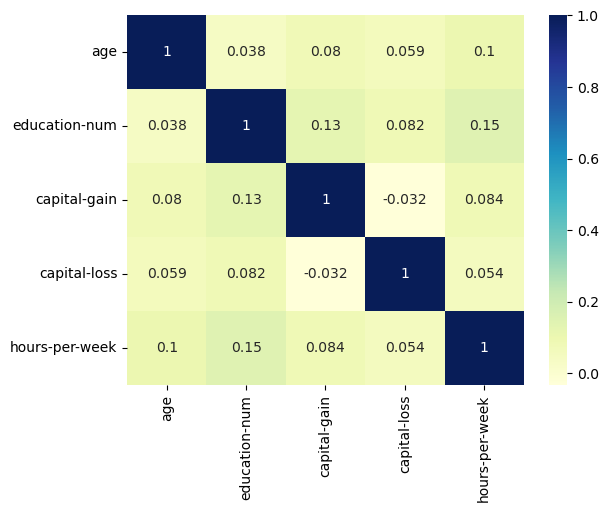

In [16]:
# Pearson correlation heatmap of numerical features
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")

This correlation matrix only includes correlations between numerical features. For a full correlation matrix that includes both numerical and categorical features, refer to the matrix below.

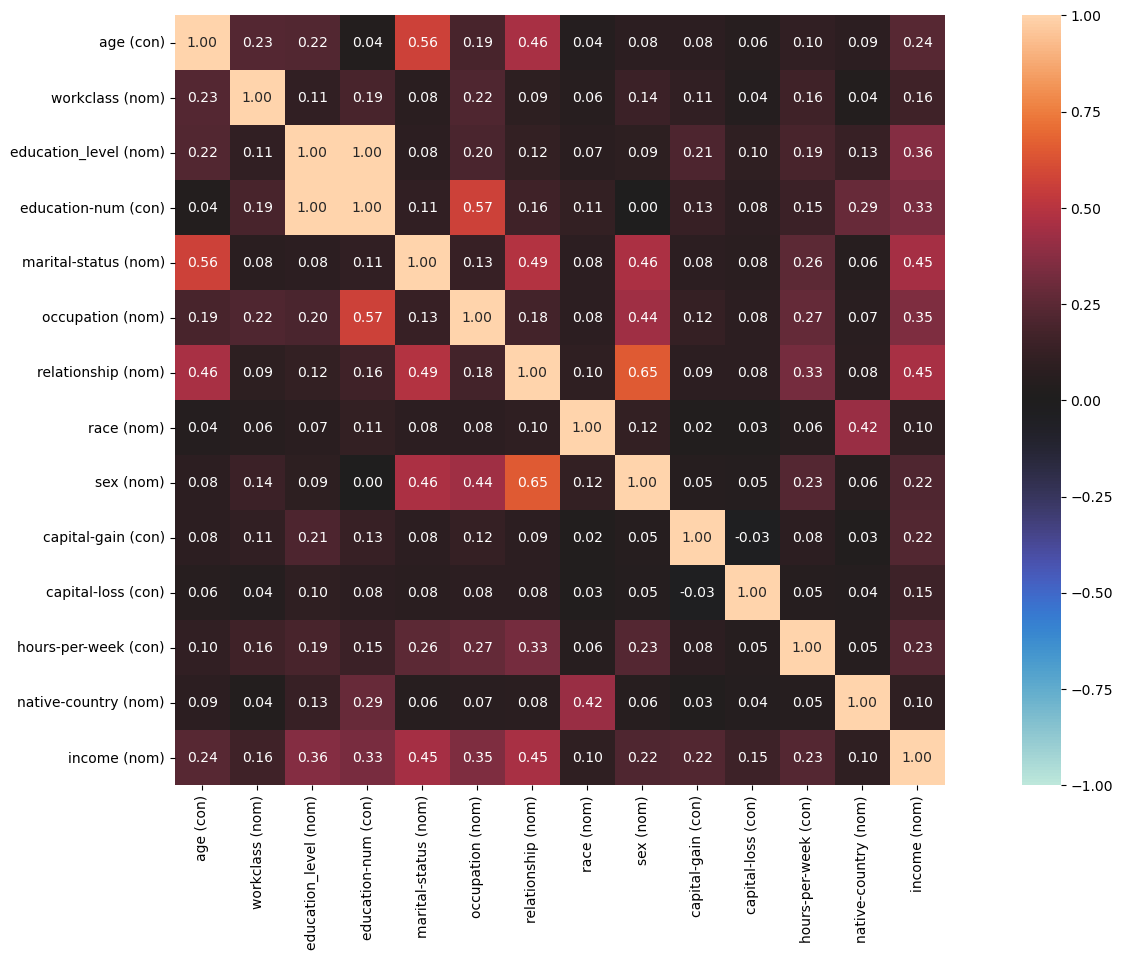

In [17]:
# Correlation matrix including categorical features
!pip install dython
from dython.nominal import associations

associations(data, nominal_columns=cat_col, figsize=(20,10), mark_columns=True);

We observe there is a perfect correlation between `"education_level"` and `"education-num"`. Therefore, one of these features can be ignored to simplify the model without losing any relevant information. We will keep `"education-num"`, as it has numerical values.

<a id="4"></a>
## 4. Feature Engineering

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will conduct Feature Engineering on the training dataset, creating reusable functions that can be later used on the testing dataset. We will begin by preprocessing continuous features, where we will apply a logarithmic transformation to features with skewed distributions, assess the presence of outliers in each feature, and normalize them using a Min-Max scaler. Next, we will move on to preprocess categorical features, where we will plot their distributions to gain some understanding on how they might impact the prediction process, and encode them using One-Hot encoding.</p></div>

<a id="4.1"></a>
### 4.1. Continuous Features

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will perform Feature Engineering to preprocess continuous features. Firstly, we will apply a logarithmic transformation to those features with a skewed distribution. Next, we will use box plots to identify outliers. And finally, we will normalize the numerical features by applying a Min-Max scaler.</p></div>

<a id="4.1.1"></a>
#### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized.

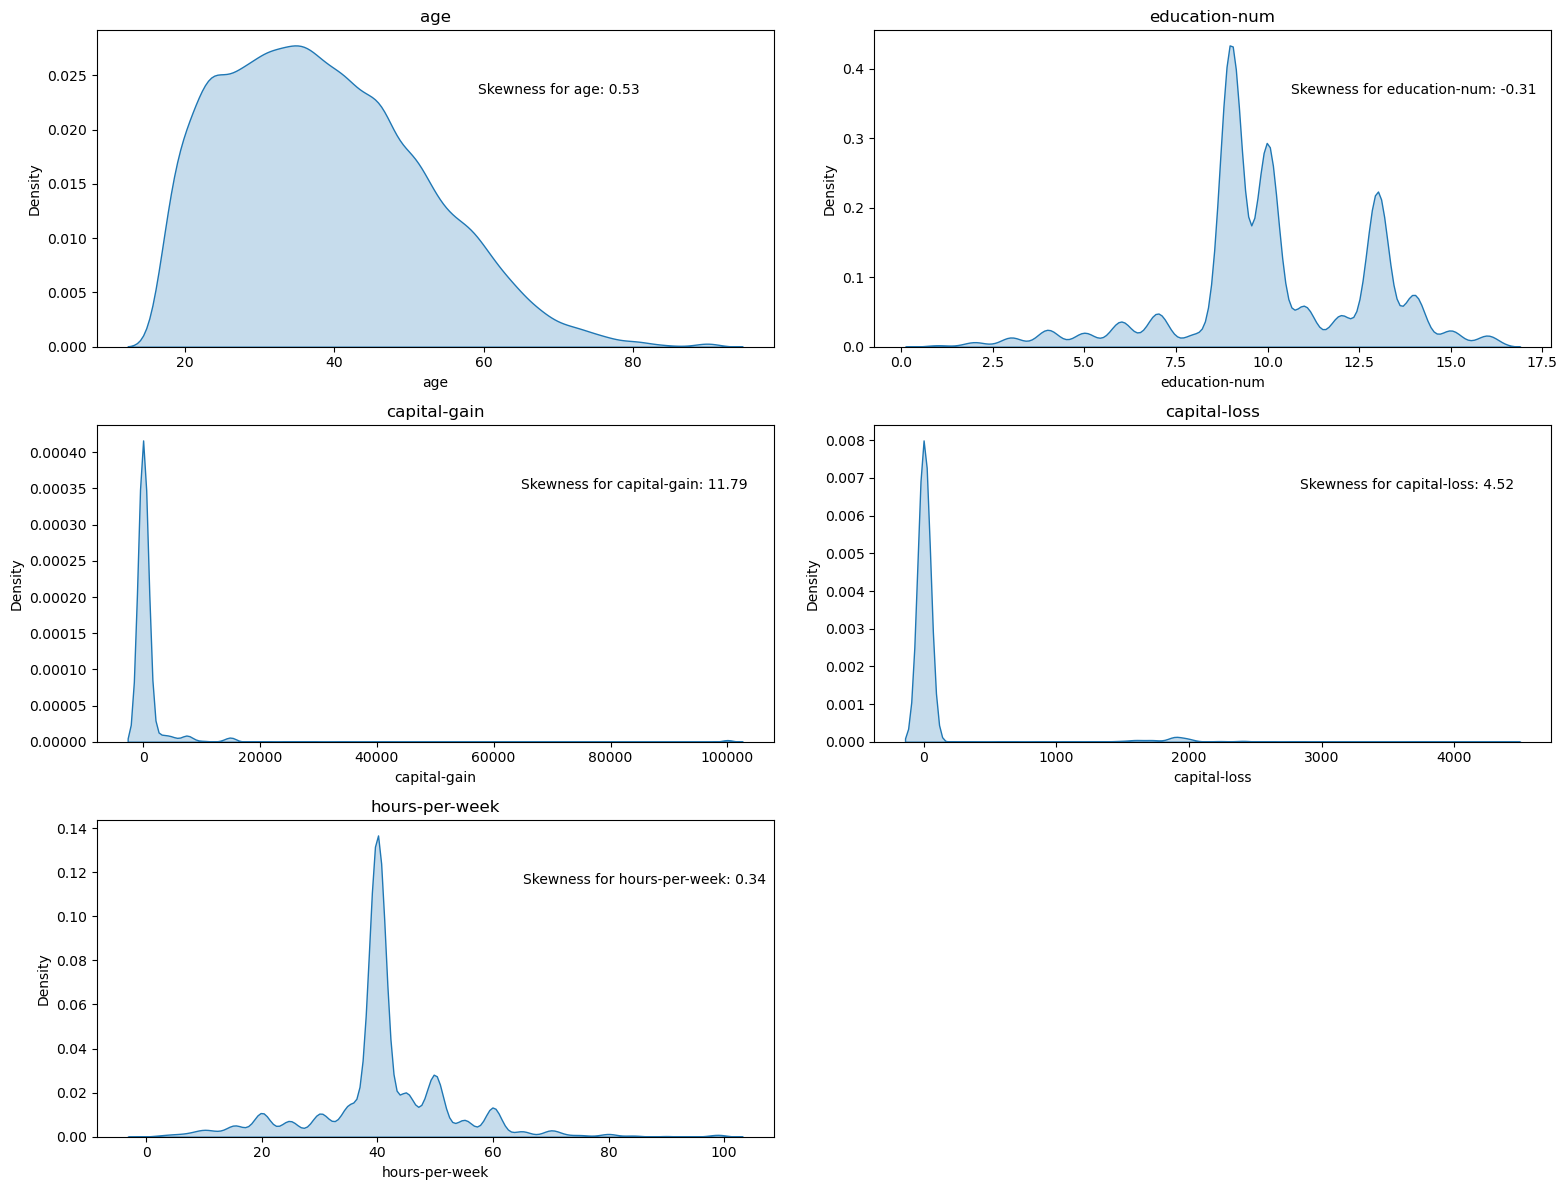

In [18]:
# Checking skewness and plotting distributions for numerical features

# Creating 3x2 grid of subplots to display graphs
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,12))
axes = axes.flatten()
axes[5].set_visible(False) # Setting the last graph to invisible

for i, column in enumerate(num_col):
    
    # Plotting distributions
    sns.kdeplot(data[column], fill=True, ax=axes[i])
    axes[i].set_title(column)
    
    # Adding skewness label
    axes[i].text(x=axes[i].get_xlim()[1]*0.6, y=axes[i].get_ylim()[1]*0.8,
                 s=f"Skewness for {str(column)}: {data[column].skew():.2f}")

plt.tight_layout()
plt.show()

A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is modetarely skewed. And a value between -0.5 and 0.5 indicates that the distributions is fairly symmetrical [[1]](#ref-01).

During the feature exploration conducted in [section 3](#3), we generated summary statistics which revealed that `"capital-gain"` and `"capital-loss"` were skewed to the right. This observation is further supported by the plots generated above, as well as the corresponding skewness values, indicating that these features exhibit significant skewness.

Algorithms can be sensitive to skewed distributions and can underperform if the range is not properly normalized. For highly-skewed feature distributions, it is common practice to apply a [logarithmic transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation, however, because the logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

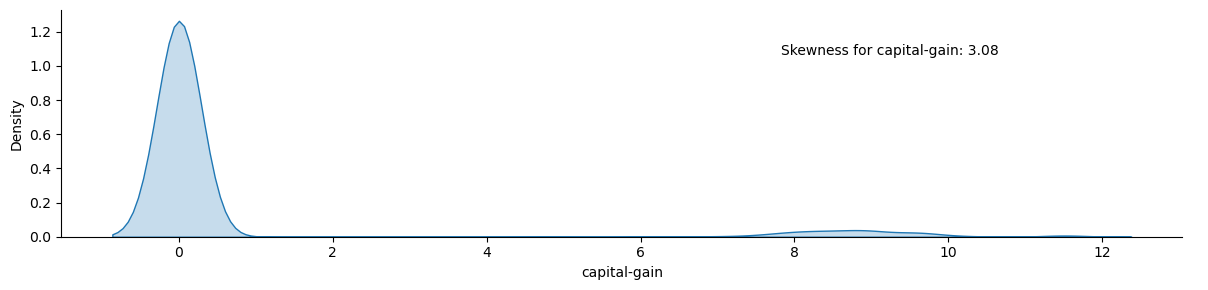

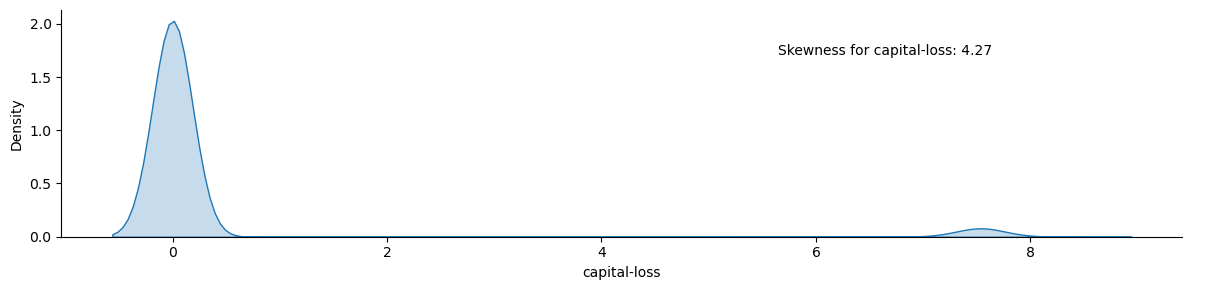

In [19]:
# Log-transform the skewed features 
skewed = ['capital-gain', 'capital-loss']

# Creating a function for later use in testing dataset
def log_transform(data):
    return data[skewed].apply(lambda x: np.log(x + 1))

# Apply transformation
data[skewed] = log_transform(data)

# Visualize the new log distributions
for column in skewed:
    g = sns.FacetGrid(data, aspect=4 )
    g.map(sns.kdeplot, column, fill=True )
    g.add_legend()
    # Adding sknewness label
    for ax in g.axes.flat:
        ax.text(x=ax.get_xlim()[1]*0.6, y=ax.get_ylim()[1]*0.8,
            s=f"Skewness for {str(column)}: {data[column].skew():.2f}")

Applying a logarithmic transformation on `"capital-gain"` and `"capital-loss"` has helped to reduce their skewness. However, these features remain highly skewed.

#### Handling Outliers

Outliers can skew data distributions and impact the accuracy and realiability of machine learning models, leading to overfitting and poor performance on new data. Handling outliers with techniques such as Trimming, Winsorizing, Log-transform or Robust Scaling can help reduce their impact and ensure more accurate and realiable results. However, it is important to first evaluate the impact of outliers and select an appropirate technique based on the characteristics of the data and modeling goals. [[2]](#ref-01) [[3]](#ref-03)

- **Trimming**: In this approach, the extreme values of the data are removed or trimmed to a certain percentage or value. This can be done by setting a threshold value for the data points, or by removing the top and bottom *n* percentiles of the data.
- **Winsorizing**: Similar to trimming, Winsorizing involves limiting the extreme values of the data by replacing them with a predetermined percentile value (e.g. replacing values above the 95th percentile with the 95th percentile value).
- **Log Transformation**: In some cases, applying a logarithmic transformation to the data can help to reduce the impact of outliers by compressing the range of the data. This can make the data more normally distributed and easier to work with.
- **Robust Scaling**: This data preprocessing technique uses the median and interquartile range (IQR) to scale and transform the features of a dataset, making it more robust to outliers and extreme values than standard scaling methods. It's particularly useful for datasets with non-normal or skewed distributions and a large number of outliers.

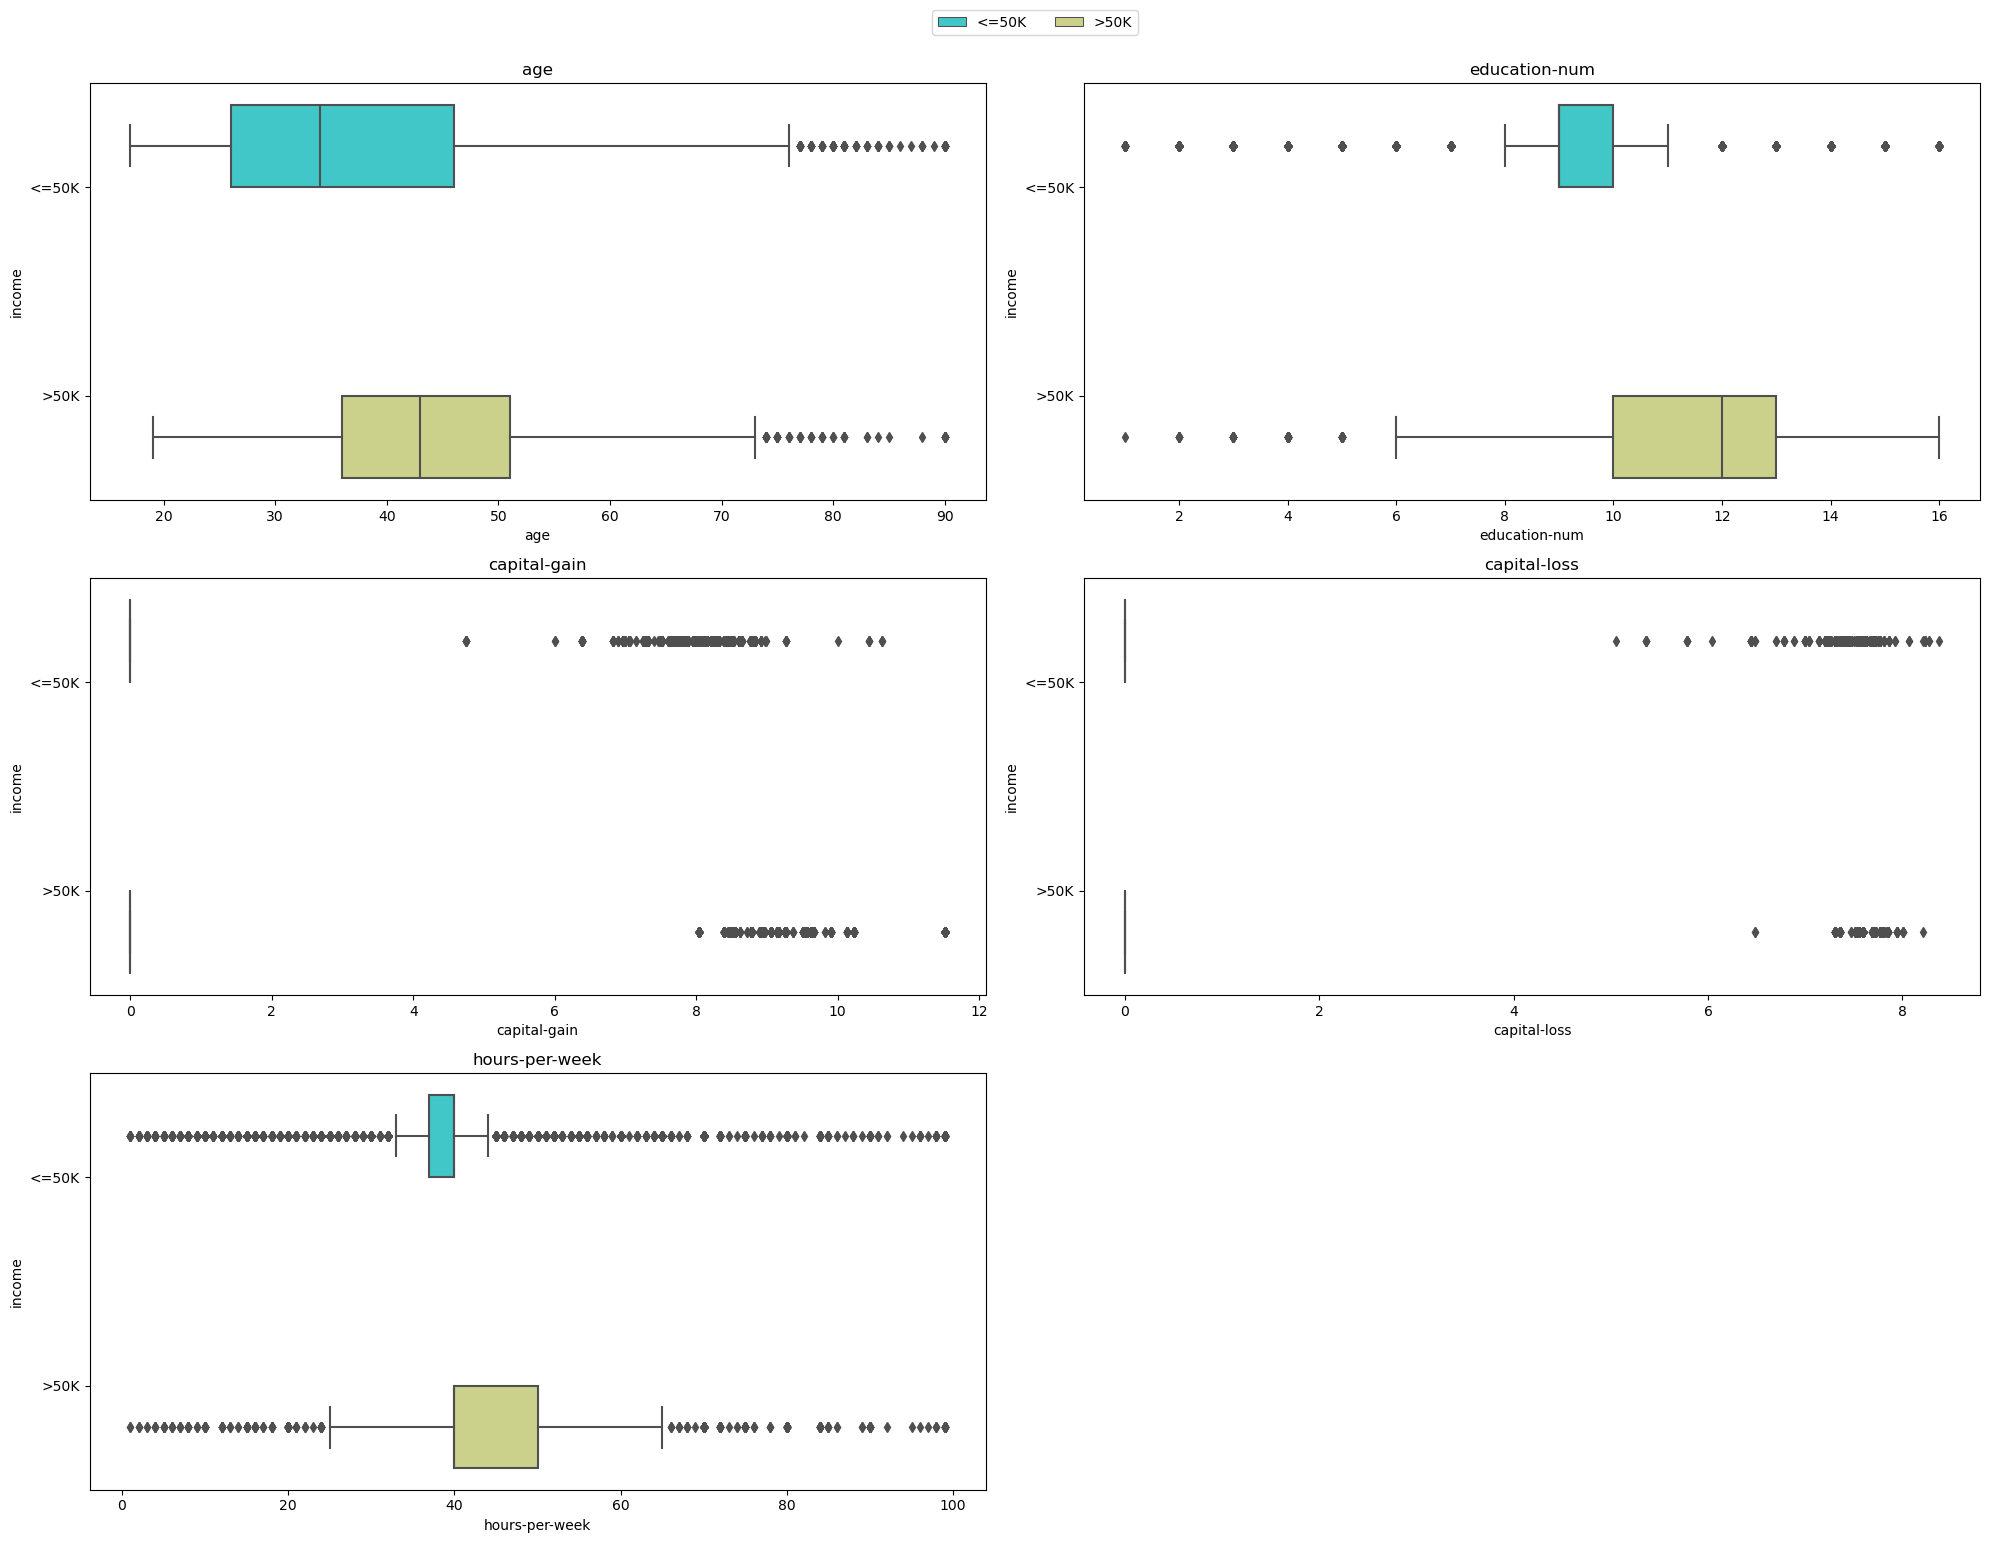

In [20]:
# Box plotting continuous features to check for outliers

# Creating 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axes = axes.flatten()
axes[5].set_visible(False) # Setting the last graph to invisible

# Generating box plots
for i, column in enumerate(num_col):
    sns.boxplot(x=column, y="income", hue="income", data=data, palette='rainbow', orient='h', ax=axes[i])
    axes[i].set_title(column)
    axes[i].legend_.remove()

# Move legend outside of plot area
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=[0.52, 1.03])    

plt.tight_layout()
plt.show()

The box plots reveal the presence of outliers in all continous variables, with the features `"capital-gain"` and `"capital-loss"` exhibiting the most significant outliers, as previously observed in the summary statistics. To address these outliers, we will apply Robust Scaling to the data, but we will first assess the model's performance on the Min-Max scaled data before proceeding with the Robust scaling. After evaluating the model's performance, we will retrain it using the Robust scaled data to determine if we can improve the performance. This process will be done in [section 6](#6).

#### Normalizing Numerical Features

Normalizing numerical features is important in many machine learning algorithms because it can improve the performance and convergence of the algorithm. Normalization involves scaling the values of the features to a common scale, which can make it easier for the algorithm to find the optimal solution. [[4]](#ref-04) [[5]](#ref-05)

Here are some reasons why normalizing numerical features is important:

- **Avoids bias**: In some algorithms, the magnitude of the features can influence the result of the algorithm. Features with larger magnitudes may dominate the algorithm and bias the solution. Normalizing the features can avoid this bias by ensuring that all features are on the same scale.
- **Improves convergence**: Normalizing features can help the algorithm to converge faster to the optimal solution. When features are on different scales, the algorithm may take longer to converge because it needs to make more iterations to adjust the weights for each feature. Normalizing the features can speed up the convergence process by reducing the number of iterations required.
- **Facilitates interpretation**: Normalizing features can make it easier to interpret the results of the algorithm. When features are on different scales, it can be difficult to compare the relative importance of each feature. Normalizing the features can make it easier to compare the coefficients or weights assigned to each feature and determine their relative importance.
- **Reduces overfitting**: Normalizing features can also help to reduce overfitting in the model. When features are on different scales, the algorithm may overemphasize the importance of certain features and create a model that is too complex. Normalizing the features can reduce the impact of outliers and reduce the complexity of the model, leading to better generalization performance on new data.

There are multiple ways to normalize features:

- **Standardization**: Standardization (also called Z-score normalization) scales the features so that they have a mean of zero and a standard deviation of one. This can be achieved by subtracting the mean of the feature and then dividing by the standard deviation. The resulting values will have a mean of zero and a standard deviation of one.
- **Min-Max Scaling**: Min-Max Scaling scales the features so that they have a minimum value of zero and a maximum value of one. This can be achieved by subtracting the minimum value of the feature and then dividing by the range (the difference between the maximum and minimum values). The resulting values will be between zero and one.
- **Log Transformation**: Log transformation is a method for normalizing features that are highly skewed or have a long tail distribution. Taking the logarithm of the values can compress the range of the values and make the distribution more normal.
- **Robust Scaling**: Robust Scaling is a method that scales the features using the median and interquartile range (IQR) instead of the mean and standard deviation. This method is less sensitive to outliers than standardization.
- **Power Transformation**: Power transformation is a method that applies a power function to the values of the feature. This can be used to transform skewed distributions into more normal distributions.

🔸 For this dataset, we will be using Min-Max Scaling to normalize numerical features.

In [21]:
# Min-Max scaling continuous features

# Creating a function for later use in testing dataset
def min_max_normalize(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data

data[num_col] = min_max_normalize(data[num_col])

data.head(n=10)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States,<=50K
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States,<=50K
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba,<=50K
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.0,0.397959,United-States,<=50K
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.0,0.153061,Jamaica,<=50K
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.448980,United-States,>50K
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.829751,0.0,0.500000,United-States,>50K
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.742849,0.0,0.397959,United-States,>50K


<a id="4.2"></a>
### 4.2 Categorical Features

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will perform Feature Engineering to preprocess categorical features. Firstly, we will plot the distributions of the categorical features to gain understanding of how they might impact the prediction process, and then we will encode them using One-Hot Encoding.</p></div>

#### Visualizing Categorical Features

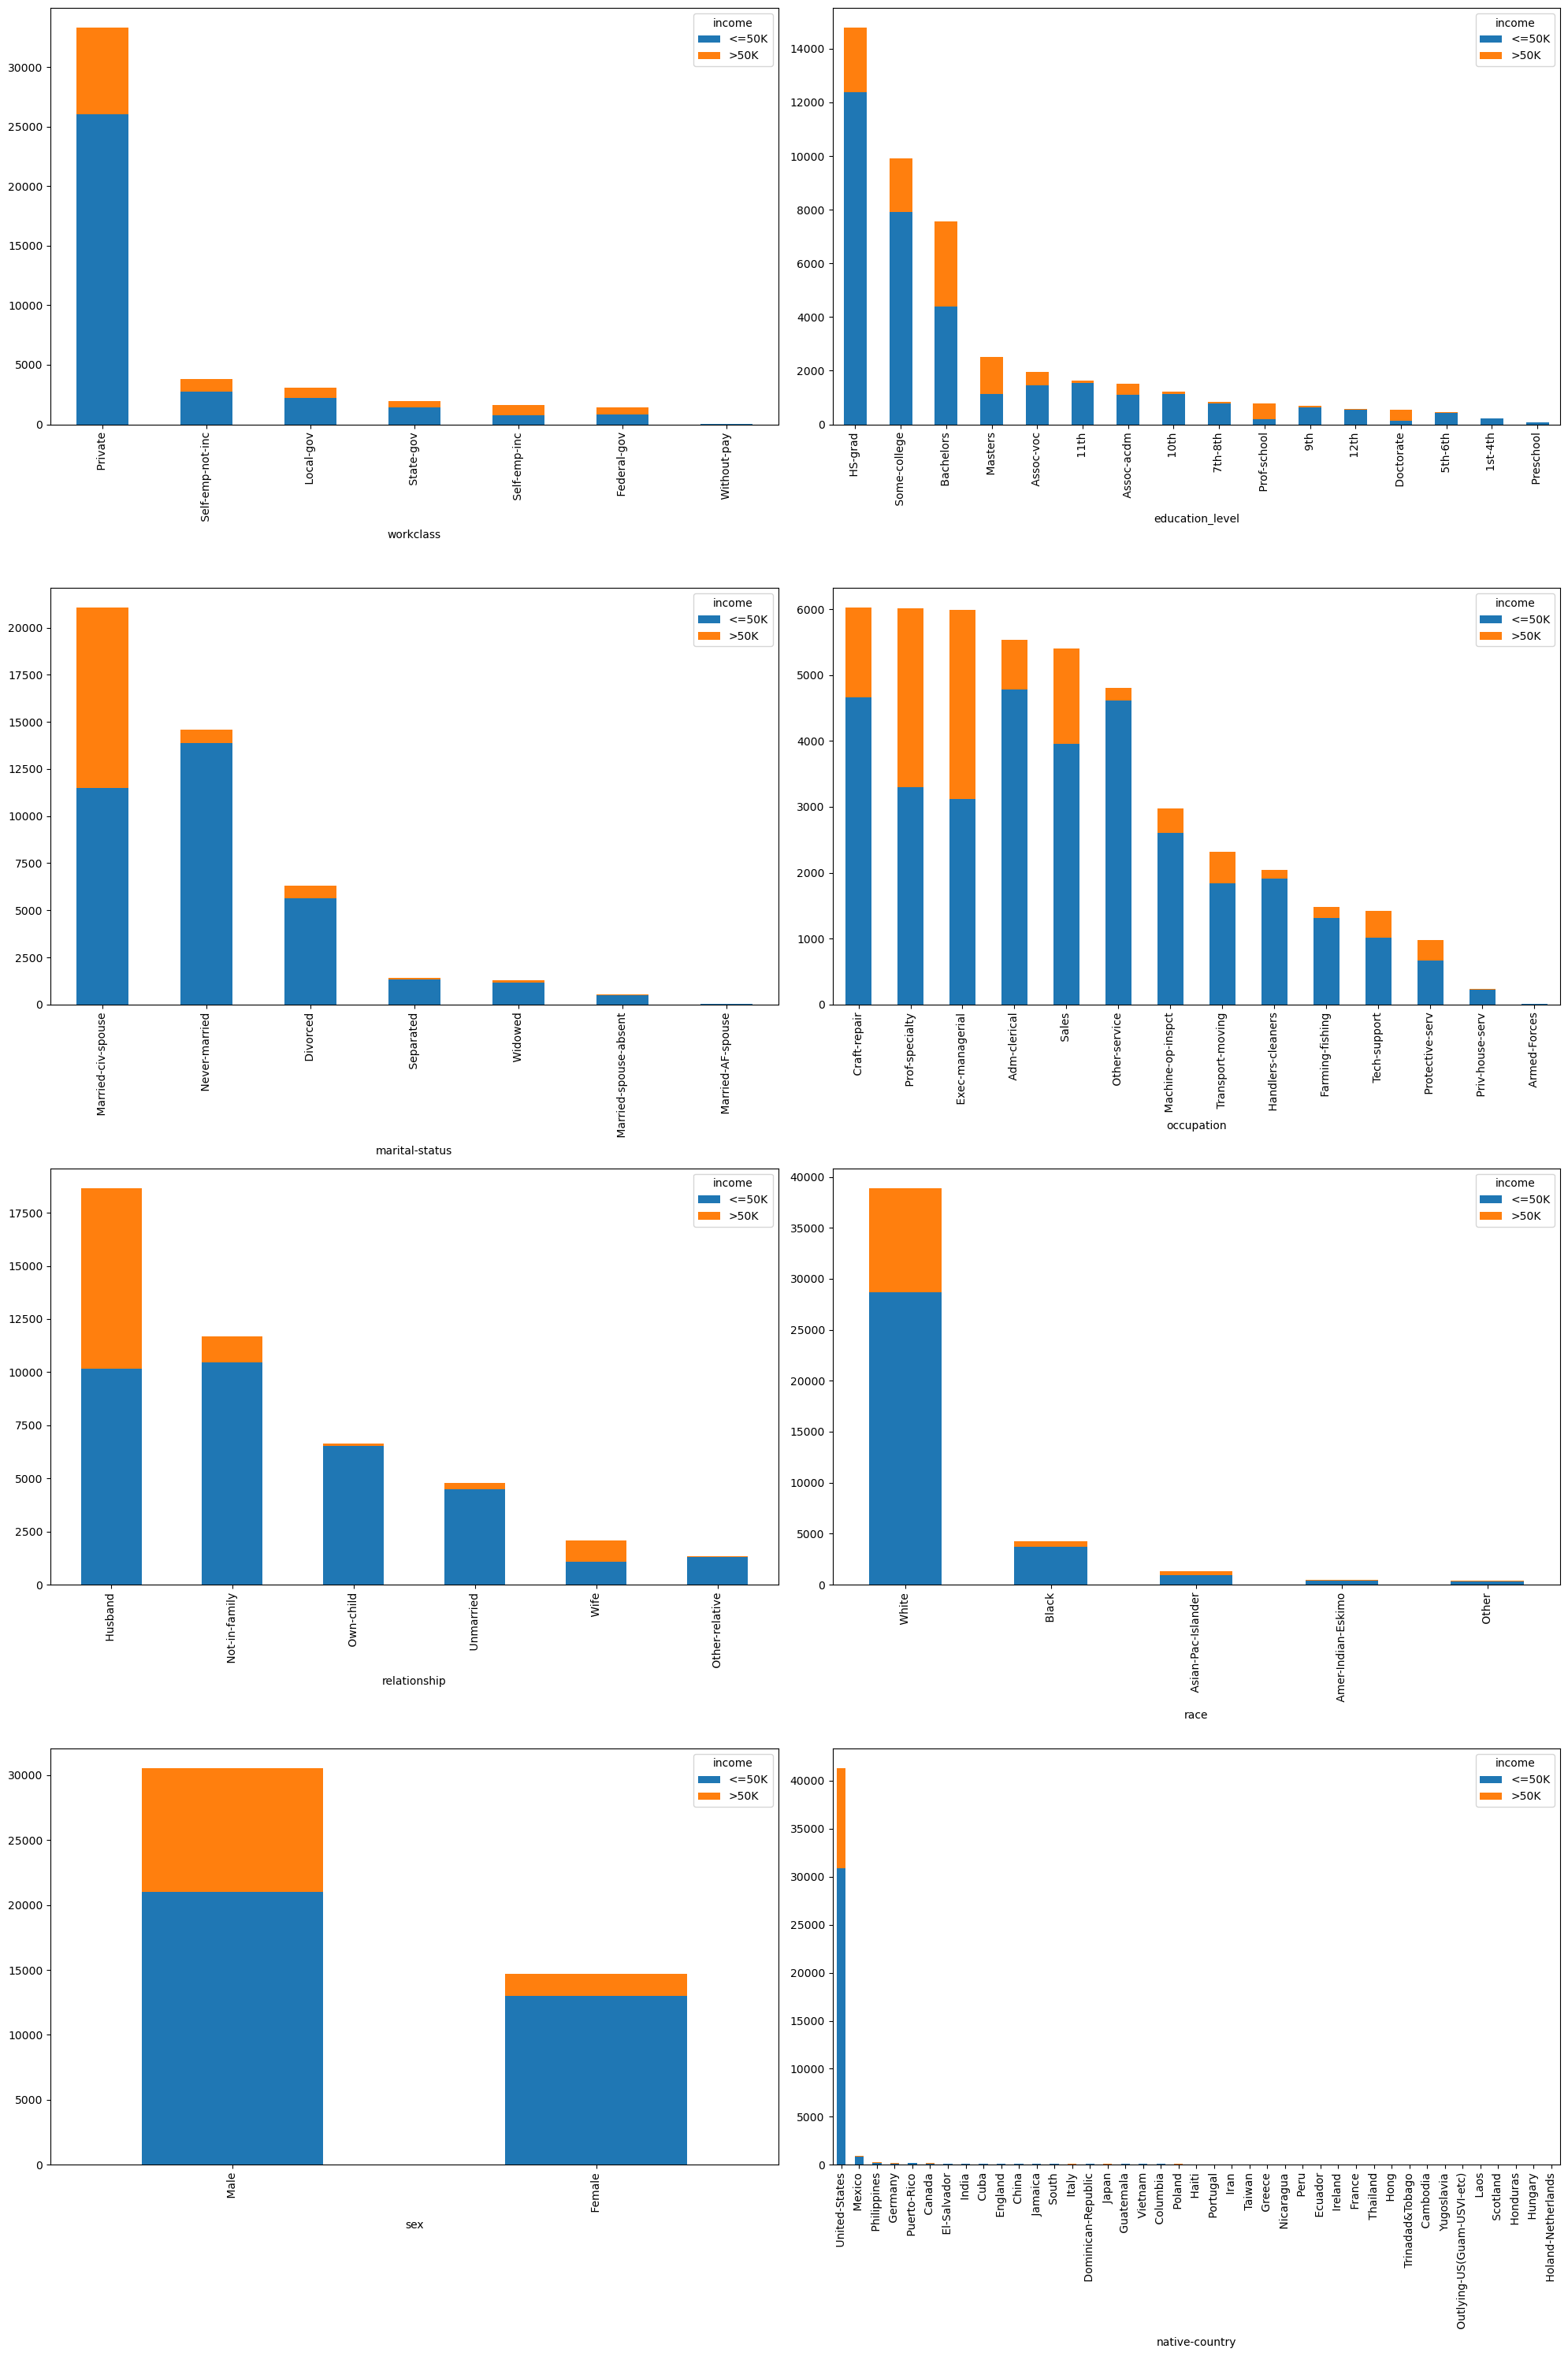

In [22]:
# Plot distributions for categorical variables

# Filtering out 'income' from list of categorical columns
cat_feat = [col for col in cat_col if col != 'income']

# Creating 4x4 grid of subplots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 30))
axs = axs.flatten()

for i, col in enumerate(cat_feat):
    
    # Creating cross-tabulation table between the column and "income" to sort by total count
    crosstab_table = pd.crosstab(data[col], data["income"])
    total_count = crosstab_table.sum(axis=1)
    sorted_idx = total_count.sort_values(ascending=False).index
    crosstab_table = crosstab_table.reindex(sorted_idx)
    
    # Creating stacked bar chart in the current subplot
    ax = crosstab_table.plot(kind="bar", stacked=True, ax=axs[i])
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

From the bar charts we can already make some clear observations:

- **Class Imbalance**: Class imbalance is present in the features `"workclass"`, `"race"` and `"native-country"`. Class imbalance occurs when one class dominates the distribution, which can indicate that the variable has limited predictive power as it may not be discriminating enough to distinguish between the classes. Approximately 74% of `"workclass"` is classified as "Private", about 86% of `"race"` is classified as "White", and approximately 91% of `"native-country"` is classified as "United-States". These statistics suggest that these features may not be good predictors of `"income"`.

- **Separation of Classes**: In the features `"marital-status"`, `"occupation"`, `"relationship"` and `"sex"`, there is a clear separation of classes. Separation of classes occurs when the distributions of the classes are dstinctly separate, which means the variable is likely to be a strong predictor of the target variable. For example, in `"occupation"`, "Prof-specialty" and "Exec-managerial" present roughly a 50/50 chance of being classified under either `"income"` label, while other classes like "Other-service", "Handlers-cleaners", and "Farming-fishing" have close to zero chances of `"income"` being higher than 50K. Similar patterns can be observed in the other listed features, suggesting they may be good predictors of `"income"`.

- **Similar Distributions**: The features `"relationship"` and `"marital-status"` exhibit almost identical distributions, with almost the same number of classes and distribution of income. For example, "Husband" from `"relationship"` and "Married-civ-spouse" from `"marital-status"` have a very similar distribution of income, as do "Not-in-family" and "Never-married", which also seem to represent the same data given their class' names. This suggests that this two features will have similar importance in predicting the outcome, regardless of their respective importance levels.

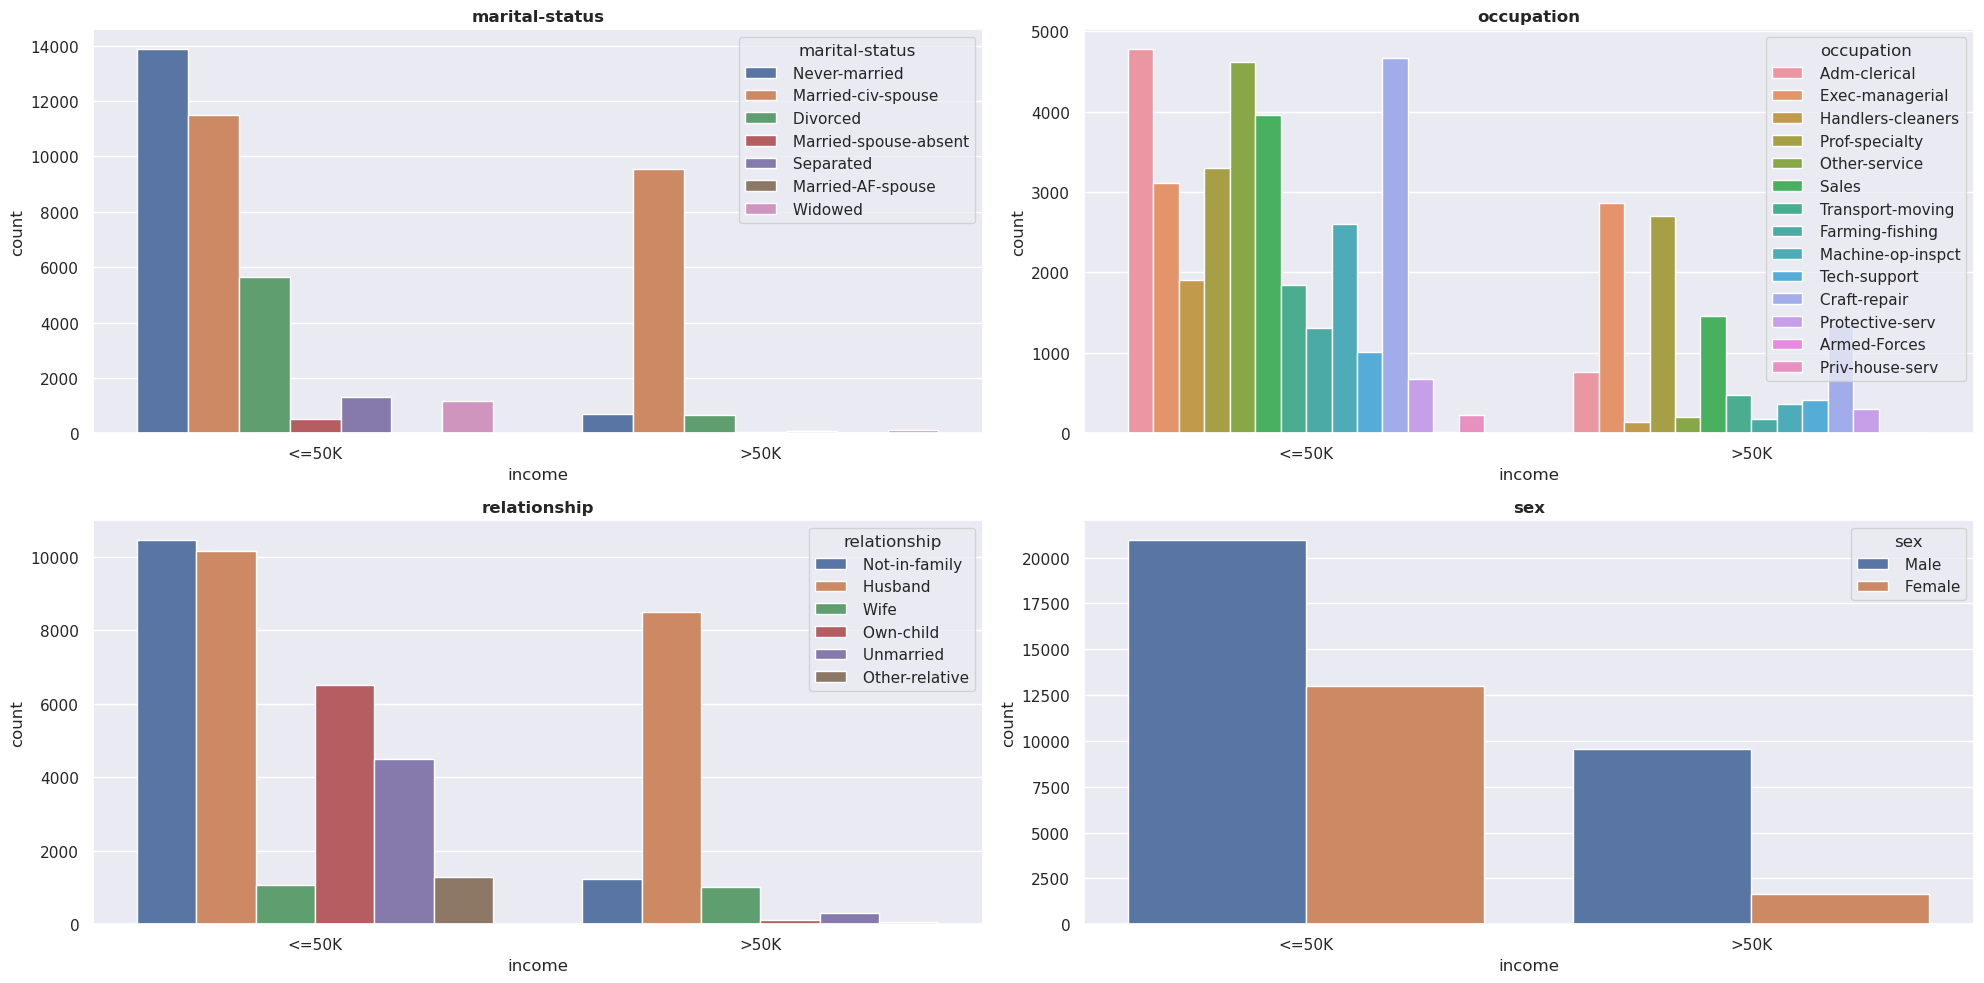

In [23]:
# Exploring separation of classes

# Distributions with separation of classes
selected = ['marital-status', 'occupation', 'relationship', 'sex']
selected_cat_col = [col for col in cat_col if col in selected]

# Creating grid of 2x2 subplots
sns.set(rc={'figure.figsize':(20,5)})
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

# Plotting graphs
for i, col in enumerate(selected_cat_col):
    sns.countplot(x='income', hue=col, data=data, ax=axes[i])
    axes[i].set_title(col, fontweight='bold')

plt.tight_layout()
plt.show()

These bar charts provide a detailed insight into the separation of classes in the features `"marital-status"`, `"occupation"`, `"relationship"`, and `"sex"`.

#### Encoding of Categorical Features

Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted.

There are several ways to encode categorical variables [[6]](#ref-06):

- **Custom Mapping**: This technique involves manually mapping each categorical value to a numerical value. For example, we can map "red" to 0, "green" to 1, and "blue" to 2. One benefit of this technique is that it allows for easy interpretation of the encoded variables. However, it can be cumbersome if there are many categorical values to map.
- **Label Encoding**: This technique involves assigning a unique integer to each categorical value. For example, "red" might be assigned 0, "green" 1, and "blue" 2. One advantage of this technique is that it's simple to implement and works well for ordinal categorical variables (where the order of categories matters). However, it can be misleading for non-ordinal categorical variables, as the assigned numbers may imply an order where none exists.
- **One-Hot Encoding**: This technique involves creating a new binary feature for each possible category in a categorical variable. For example, a variable with values "red", "green", and "blue" would be encoded as three binary features: one for "red", one for "green", and one for "blue". This technique is useful because it preserves all the information in the original categorical variable, and allows for easy interpretation of the encoded variables. However, it can be memory-intensive if there are many categories, and can lead to the "curse of dimensionality" if there are many categorical variables.
- **Binary Encoding**: This technique is similar to One-Hot Encoding, but instead of creating one binary feature for each category, it creates log2(k) features, where k is the number of categories. This is done by assigning each category a unique binary code, where each digit in the code corresponds to a power of 2. For example, if there are 8 categories, we would assign the binary codes 000, 001, 010, 011, 100, 101, 110, and 111. This technique is useful because it's more memory-efficient than One-Hot Encoding, and still preserves all the information in the original categorical variable. However, it can be less interpretable than One-Hot Encoding.

🔸 For this dataset, we will be using One-Hot Encoding to encode the categorical features and a simple custom mapping to encode the target variable.

In [24]:
# One-Hot Encoding of all the features (except "education_level")
features_encoded = pd.get_dummies(data.drop(["education_level", "income"], axis = 1))

# Print the number of features after one-hot encoding
encoded = list(features_encoded.columns)
print("Total features after One-Hot Encoding:", len(encoded))

# Mapping of target variable "income"
income = data["income"].apply(lambda x: 0 if x == "<=50K" else 1)

Total features after One-Hot Encoding: 87


<a id="5"></a>
## 5. Modelling

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will build a supervised learning model for the dataset. We will start by splitting the data into training and testing sets and defining the evaluation metrics for comparing six different models. Then, after selecting which models to use for modelling the dataset, and we will compare their performance metrics and choose the best-performing model. Finally, we will perform hyperparameter tuning on the selected model to obtain the best possible performance.</p></div>

<a id="5.1"></a>
### 5.1. Splitting the Data

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will split the data intro training and testing sets. 80% of the data will be used for training and 20% for testing.</p></div>

In [25]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded,
                                                    income,
                                                    test_size = 0.2,
                                                    random_state = 0)

# Show results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


<a id="5.2"></a>
### 5.2. Evaluating Performance

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will define which evaluation metrics to compare from the six different supervised leraning algorithms we will be using to model the data. Then, we will establish benchmark metrics for the dataset using a Dummy Classifer.</p></div>

#### Evaluation Metrics

*CharityML*, equipped with their research, knows individuals that make more than \$50K are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50K accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50K as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50K is *more important* than the model's ability to **recall** those individuals.

We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

- **Accuracy**: Measures the ratio of correct predictions made by the model to the total number of predictions.
- **Precision**: Measures the ratio of true positive predictions to the total number of positive predictions.
- **Recall**: Measures ratio of true positive predictions to the total number of actual positive instances in the dataset. [[7]](#ref-07)

For classification problems that are skewed in their classification distributions, like this one, accuracy by itself is not a very good metric. We saw earlier that only aprox. 25\% of individuals make more than \\$50K, while aprox. 75\% make less than \$50K. If we classified all individuals as making less than \\$50K, we would still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is a weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score.

For this problem, the success of the model will be determined based on the models' **AUC** or area under the curve associated with ROC curves.

- **ROC-AUC score**: Measures the model's ability to distinguish between positive and negative classes by calculating the area under the receiver operating characteristic curve, with a score of 0.5 indicating random guessing and a score of 1 indicating perfect classification. [[8]](#ref-08)

🔸 Therefore, we will be evaluating and comparing the F-scores and, more specifically, the ROC-AUC scores of the selected models to determine which performs best.

#### Benchmarking

To establish a baseline accuracy, F1 score and ROC-AUC score, we will use a benchmark model. Benchmark models are used as a baseline comparison for more complex models to determine whether the additional complexity is warranted. Two examples are: 

- **Naive Classifier**: Is a model that assumes all features are independent of each other and makes predictions based on the probability of each feature occurring independently. This is called the "naive" assumption becuase it is a simplification that may not hold true in many real-world scenarios. For example, a naive classifier might assume that the likelihood of a peroson having a heart attach is independent of their age, gender, and smoking status, which is not cesessarily true. [[9]](#ref-09)

- **Dummy Classifier**: Is a model that makes predictions based on a simple heuristic or random guess. For example, a dummy classifier might always predict the most frequent class in the training data. If a more complex model can't perform better than a simple dummy classifier, it may indicate that the problem is inherently difficult or that the data is noisy or uninformative. [[10]](#ref-10)

🔸 To establish a benchmark for this dataset, we will be using a Dummy Classifier.

In [28]:
# Benchmark Model

# Creating a Dummy Classifier that will always predict the most frequent class
dummyClassifier = DummyClassifier(strategy = "most_frequent")
dummyClassifier.fit(data, income)
pred = dummyClassifier.predict(data)

# Save results for later use
benchmark_accuracy = accuracy_score(income, pred)
benchmark_f1 = f1_score(income, pred)
benchmark_roc = roc_auc_score(income, pred)

# Show results
print("Accuracy Score:", benchmark_accuracy)
print("F1 Score:", benchmark_f1)
print("ROC-AUC Score:", benchmark_roc)

Accuracy Score: 0.7521560302507629
F1 Score: 0.0
ROC-AUC Score: 0.5


An `F-score` of 0 means that the model has failed to make any correct positive predictions, or has predicted only negative instances. This can happen if the dataset is imbalanced.

The `ROC-AUC Score` of 0.5 means that the benchmark model's predictions are no better than random guessing.

<a id="5.3"></a>
### 5.3. Choosing a Supervised Learning Model

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will go through six supervised learning models and what makes them good candidates for this problem. Later, we will analyse the six model's performance and choose the most accurate model based on the AUC score.</p></div>

- **Logistic Regression**: Given the dataset presents a binary classification problem, Logistic Regression can be a good model candidate assuming the relationships between the features and the target variable (income) are not too complex. The sample size of this dataset (45222) is much greater than the number of features (103), and the set of possible outcomes is discrete (<=50K or >50K), which makes Logistic Regression well-suited for this problem. However, it makes some assumptions that might be mistaken; like a linear relationship between the features and the logit of the outcome, and no correlation between the features, which might not be the case.

    - Strengths of the model [[11]](#ref-11):
        - Simple and easy-to-understand statistical method. Efficient to train and interpret, which can be useful for communicating results to a non-technical audience.
        - Doesn't make assumptions about distributions of classes in feature space and can be extended to multiple classes (multinomial regression).
        - Provides a measure of how appropriate a predictor is (coefficient size) and also its relationship with the outcome variable, i.e. direction of association (positive or negative).<br><br>

    - Weaknesses of the model [[11]](#ref-11) [[12]](#ref-12):

        - Constructs linear boundaries, i.e. assumes that there is a linear relationship between the predictor variables and the logit of the outcome, which may not always be the case in real-world scenarios.
        - Requires a large sample size to produce accurate estimates. Particularly, if the number of observations is lesser than the number of features it may lead to overfitting.
        - Can only be used to predict discrete functions (classification problems). Hence, the target variable is bound to be a discrete number set. Can also be affected by multicollinearity between independent variables, which makes it difficult to identify the unique contribution of each predictor value.<br><br>
        
- **Naive Bayes**: Given the dataset presents a binary classification problem, Naive Bayes can be a good model candidate. This model can handle high-dimensional data with a small number of training samples, and the set of possible outcomes, in this case, is discrete (<=50K or >50K), which makes it well-suited for this problem. However, it relies on the assumption of independence between features, which might not be realistic for this particular problem. Nonetheless, it is a relatively easy-to-implement model and is known for its robustness against overfitting and noise.

    - Strenghts of the model [[13]](#ref-13) [[14]](#ref-14):
        - Can handle high-dimensional data with a small number of training samples, if the assumption of independence of features holds true.
        - Is robust to noise and overfitting, and can be used for both binary and multi-class classification problems.
        - Can be trained efficiently and is relatively easy to implement.<br><br>
        
    - Weaknesses of the model [[13]](#ref-13) [[14]](#ref-14):
        - Makes strong independence assumptions between features, which may not always be true in real-world scenarios.
        - May not work well with continuous features, as it assumes a discrete distribution for the features.
        - Is strictly a classification algorithm, and can't be used to predict continuous numerical values.<br><br>

- **Support Vector Machines (SVM)**: Given the dataset presents a binary classification problem and has a small number of samples (<100K), SVM can be a good model candidate. Since the relationships between the features and target variable (income) may be of any dimensionality, we can experiment with different kernel functions (linear, polynomial, RBF...) to identify the best fit for the given dataset. Assuming the dataset is not excessively noisy or has overlapping classes, SVM is well-suited for this classification problem due to its versatility adapting to high-dimensional, linear and non-linear problems; which can potentially lead to a good generalization performance.

    - Strengths of the model [[15]](#ref-15) [[16]](#ref-16):

        - Works well handling high-dimensional data with a small number of training samples, since it only requires a small number of support vectors to define the boundary.
        - Can model non-linear decision boundaries by using different kernel functions.
        - Is robust to outliers in the data (noise), has good generalization performance, and can be used for both classification and regression problems.<br><br>

    - Weaknesses of the model [[17]](#ref-17):

        - Can be computationally expensive for large datasets with many features, as the algorithm requires solving a quadratic optimization problem.
        - The choice of kernel (and hyperparameters) can greatly affect the performance of the model, and it can be difficult to determine the best kernel for a given dataset.
        - Doesn't work well when the dataset has overlapping classes.<br><br>
        
- **Random Forests**: Given that the dataset has a small number of samples (<100K) and many features (103), Random Forests can be a good model candidate for this problem, particularly if the dataset is high-dimensional with complex relationships between the features and the target variable (income).

    - Strenghts of the model [[18]](#ref-18) [[19]](#ref-19):
        - Can handle high-dimensional data (both categorical and numerical data) with a small number of training samples, since it uses multiple Decision Trees and aggregates their predictions.
        - Can model non-linear decision boundaries and interactions between features, and can be used for both classification and regression problems.
        - Is robust to noise and overfitting, achieved by [binning](https://en.wikipedia.org/wiki/Data_binning) the input space. And is generally a low bias, low variance model, which is achieved by averaging all the trees in the Random Forest, hence averaging the variance of each Decision Tree.<br><br>
        
    - Weaknesses of the mode [[18]](#ref-18) [[19]](#ref-19):
        - Can be computationally expensive for large datasets with many features, as the algorithm requires training and aggregating multiple Decision Trees.
        - Are not easily interpretable. They provide feature importance but don't give complete visibility into the coefficients, since it's no longer clear which variables are most important when we have a large number of trees.
        - Can be sensitive to noisy data, especially if the weak models overfit to the noise.<br><br>
        
- **Bagging**: Can be a good model candidate for this problem, especially if the dataset is noisy or has many outliers. Bagging is well-suited for this classification problem because it can reduce variance and improve the performance of unstable models. In combination with one-level Decision Tree estimators (stumps), Bagging could lead to a highly accurate model for this problem.

    - Strenghts of the model [[20]](#ref-20) [[21]](#ref-21) [[22]](#ref-22):
        - Can significantly reduce the variance and increase the accuracy of the model by using bootstrap samples of the training data and aggregating the predictions.
        - Performs well on high-dimensional data, and isn't affected by missing values in the dataset.
        - Can handle a wide range of classification and regression problems and is relatively easy to implement.<br><br>
        
    - Weaknesses of the model [[20]](#ref-20) [[21]](#ref-21) [[22]](#ref-22):
        - Can be computationally expensive for large datasets and models, as it requires training and aggregating multiple models.
        - Is not easily interpretable. It provides feature importance but doesn't give complete visibility into the coefficients, since it's no longer clear which variables are most important when we have a large number of trees.
        - Can be sensitive to noisy data, especially if the weak models overfit to the noise, resulting in high bias.<br><br>

- **AdaBoost**: Given the dataset presents a binary classification problem, AdaBoost can be a good model candidate, especially if the dataset has complex relationships between the features and the target variable (income). Assuming the dataset has few bad-quality samples (i.e., noise and outliers), AdaBoost in combination with one-level Decision Tree estimators (stumps) could lead to a highly accurate model for this problem.

    - Strengths of the model [[23]](#ref-23) [[24]](#ref-24):

        - Easy-to-use algorithm, mainly because it requires less hyperparameter tunning in comparison with other models.
        - Known for its high accuracy, because it combines multiple weak learners to form a strong classifier.
        - Not prone to overfitting, as the input parameters are not jointly optimized, and can be applied to a wide range of problems, such as binary classification, multi-class classification, regression, and outlier detection.<br><br>

    - Weaknesses of the model [[23]](#ref-23) [[24]](#ref-24):

        - Extremely sensitive to noisy data and outliers, since it uses a progressively learning boosting technique.
        - Performance can be negatively affected by weak classifiers with low predictive power.
        - The training process can be computationally expensive and time-consuming.

#### Building a Pipeline

To evaluate the performance of each model, we will create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [26]:
# Training and Predicting Pipeline

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    Parameters:
       - learner (object): The learning algorithm to be trained and predicted on
       - sample_size (int): The size of samples (number) to be drawn from training set
       - X_train (pd.DataFrame): Features training set
       - y_train (pd.Series): Income training set
       - X_test (pd.DataFrame): Features testing set
       - y_test (pd.Series): Income testing set
       
    Returns:
       - results (dict): Results for training and prediction times, accuracy, F1, and ROC-AUC scores.
    '''
    
    results = {}
    
    # Fitting the learner to the training data
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculating the training time
    results['train_time'] = end - start
        
    # Getting the predictions on the test set (X_test) and on the first 300 training samples (X_train)
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculating the total prediction time
    results['pred_time'] = end - start
            
    # Computing accuracy on the first 300 training samples and test set
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Computing F-score on the the first 300 training samples and test set
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    
    # Computing ROC-AUC score on the first 300 training samples and test set
    results['roc_train'] = roc_auc_score(y_train[:300], predictions_train)
    results['roc_test'] = roc_auc_score(y_test, predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

#### Evaluating the Models

In [30]:
# Initialize the six models
clf_lr = LogisticRegression(random_state=42, max_iter=1000)
clf_nb = GaussianNB()
clf_svc = SVC(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)
clf_bag = BaggingClassifier(random_state=42)
clf_ada = AdaBoostClassifier(random_state=42)

# Collect results on the learners
results = {}
samples = len(y_train) # Entire training set
for clf in [clf_lr, clf_nb, clf_svc, clf_rf, clf_bag, clf_ada]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 36177 samples.
GaussianNB trained on 36177 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 36177 samples.
BaggingClassifier trained on 36177 samples.
AdaBoostClassifier trained on 36177 samples.


These models were trained using **default hyperparameter values**. Further analysis will involve fine-tuning some of these hyperparameters to optimize the chosen model's performance.

- LogisticRegression [[25]](#ref-25):
    - `penalty`: Type of regularization to apply (L1 or L2) (default='l2')
    - `C`: Inverse of regularization strength (default=1.0)
    - `solver`: Algorithm to use in optimization problem (liblinear, lbfgs, saga) (default='lbfgs') <br><br>
    
- GaussianNB: No hyperparameters to tune.
    
- SVC [[26]](#ref-26):
    - `C`: Regularization parameter (default=1.0)
    - `kernel`: Type of kernel function to use (linear, poly, rbf, sigmoid) (default='rbf')
    - `gamma`: Kernel coefficient for rbf, poly and sigmoid kernels (default='scale')<br><br>
    
- RandomForestClassifier [[27]](#ref-27):
    - `n_estimators`: Number of trees in the forest (default=100)
    - `criterion`: Function to measure the quality of a split (gini or entropy) (default='gini')
    - `max_depth`: Maximum depth of the tree (default=None)
    - `min_samples_split`: Minimum number of samples required to split an internal node (default=2)<br><br>
    
- BaggingClassifier [[28]](#ref-28):
    - `estimator`: Estimator to fit on each bootstrap sample (default=None. If None, then the base estimator is a DecisionTreeClassifier)
    - `n_estimators`: Number of base estimators in the ensemble (default=10)
    - `max_samples`: Maximum number of samples to draw from X to train each base estimator (default=1.0)<br><br>
    
- AdaBoostClassifier [[29]](#ref-29):
    - `estimator`: Estimator to use as base learner (default=None. If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1)
    - `n_estimators`: Maximum number of estimators at which boosting is terminated (default=50)
    - `learning_rate`: Learning rate shrinks the contribution of each classifier by learning_rate (default=1.0)

#### Visualizing Results

In [31]:
# Creating visualization code to compare results of various learners

def evaluate(results, benchmark_accuracy, benchmark_f1, benchmark_roc):
    """
    Visualization code to display results of various learners.
    
    Parameters:
      - results (dict): Results for training and prediction times, accuracy, F1, and ROC-AUC scores for each model
      - benchmark_accuracy (float): The accuracy score of the benchmark model
      - benchmark_f1 (float): The F1 score of the benchmark model
      - benchmark_roc (float): The ROC-AUC score of the benchmark model
    """
  
    # Create figure
    fig, ax = plt.subplots(4, 2, figsize=(18, 18))

    # Constants
    bar_width = 1
    colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65"]
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'pred_time', 'acc_train', 'acc_test', 'f_train', 'f_test', 'roc_train', 'roc_test']):
                # Plot bars
                ax[j//2, j%2].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
                # Add values on top of each bar
                ax[j//2, j%2].text(k*bar_width, results[learner][metric] + 0.01, round(results[learner][metric], 2), ha='center', va='bottom', fontsize=10)
                
    # Add horizontal lines for dummy classifiers
    ax[1, 0].axhline(y = benchmark_accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = benchmark_accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[2, 0].axhline(y = benchmark_f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[2, 1].axhline(y = benchmark_f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[3, 0].axhline(y = benchmark_roc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[3, 1].axhline(y = benchmark_roc, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    # Add y-labels
    ax[0, 0].set_ylabel("Time (s)")
    ax[0, 1].set_ylabel("Time (s)")
    ax[1, 0].set_ylabel("Accuracy Score")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[2, 0].set_ylabel("F1 Score")
    ax[2, 1].set_ylabel("F1 Score")
    ax[3, 0].set_ylabel("ROC-AUC Score")
    ax[3, 1].set_ylabel("ROC-AUC Score")

    # Add x-labels
    ax[3, 0].set_xlabel("Models")
    ax[3, 1].set_xlabel("Models")

    # Add titles
    ax[0, 0].set_title("Model Training Time")
    ax[0, 1].set_title("Model Prediction Time")
    ax[1, 0].set_title("Accuracy Score on Training Subset")
    ax[1, 1].set_title("Accuracy Score on Testing Subset")
    ax[2, 0].set_title("F1 Score on Training Subset")
    ax[2, 1].set_title("F1 Score on Testing Subset")
    ax[3, 0].set_title("ROC-AUC Score on Training Subset")
    ax[3, 1].set_title("ROC-AUC Score on Testing Subset")
    
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.08, 4.9), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'medium')

    # Set y-limits for score panels
    ax[2, 0]

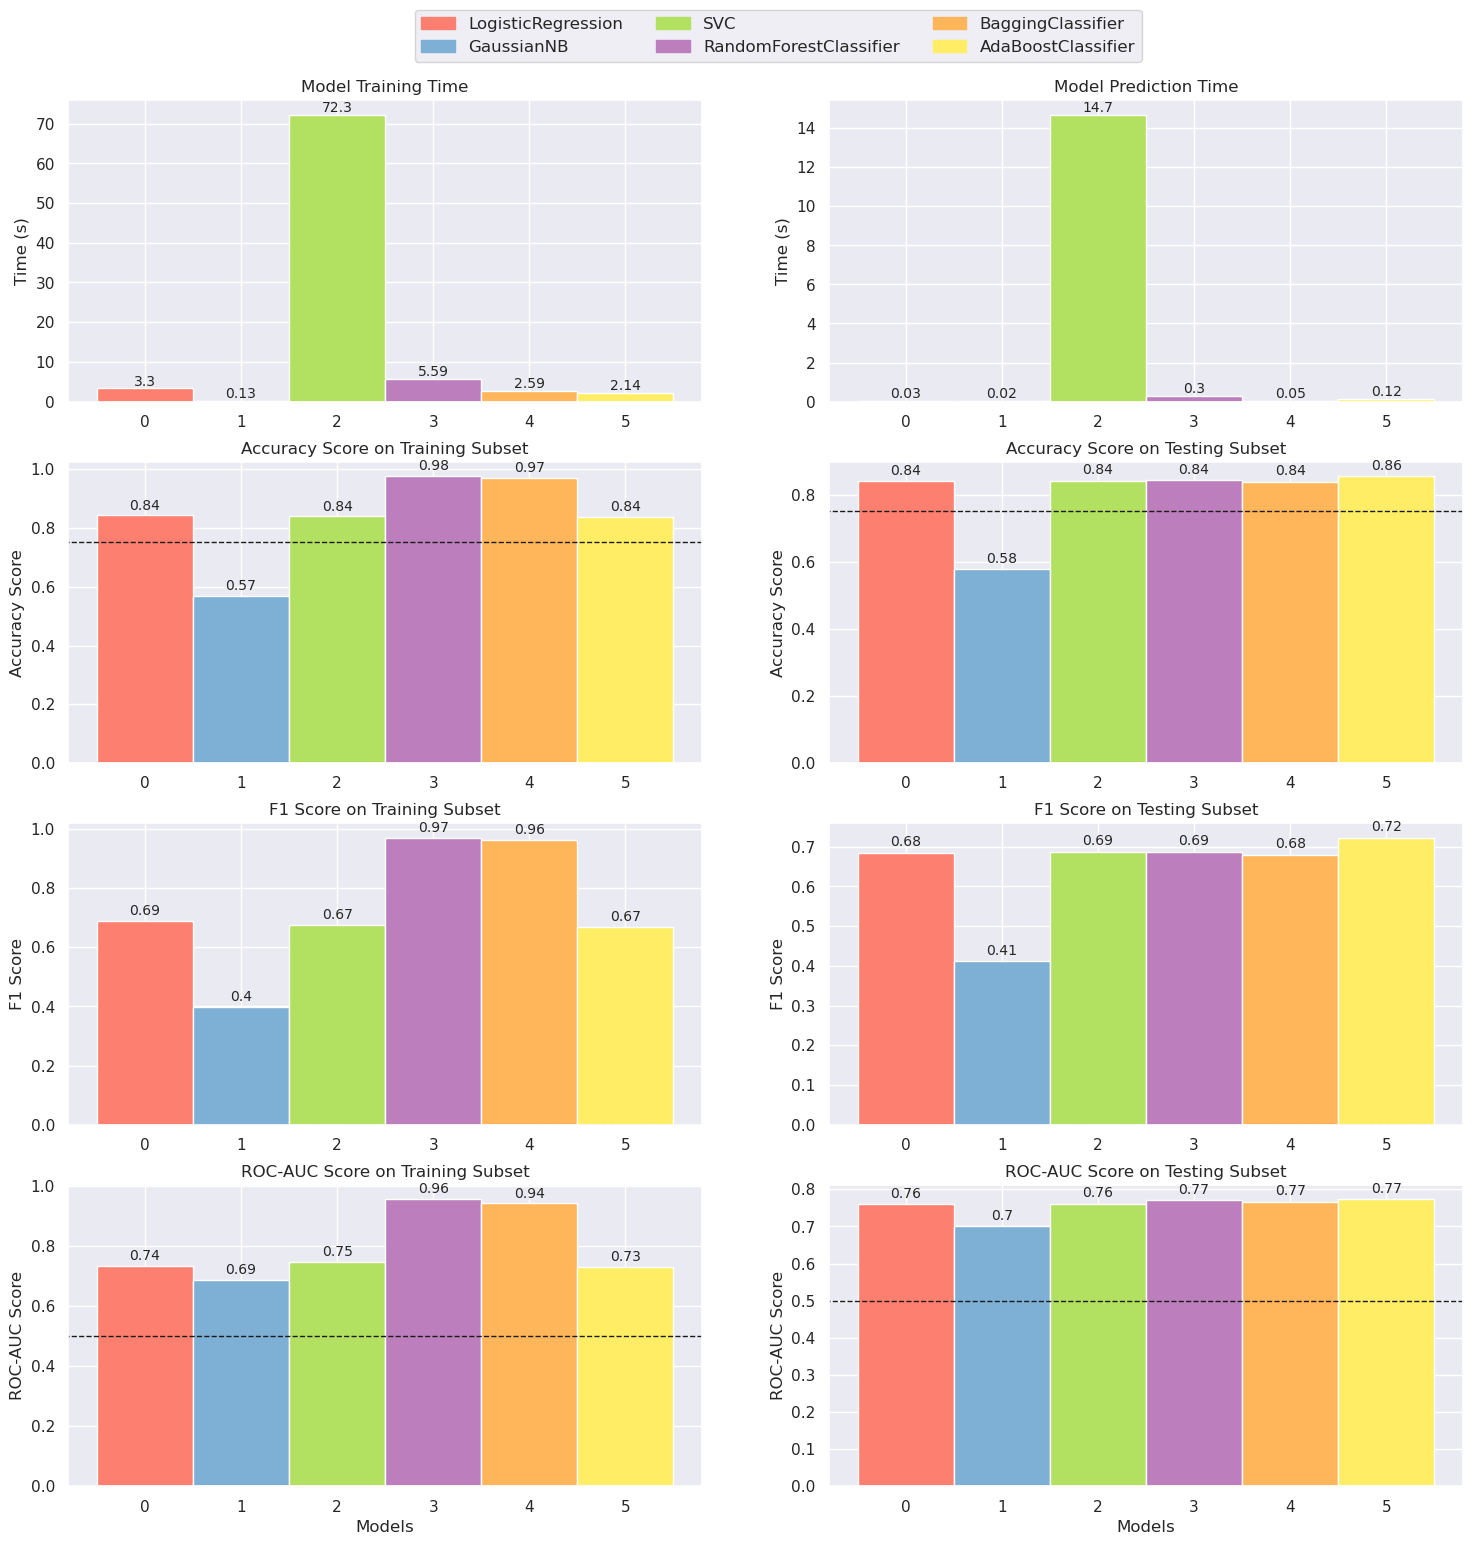

In [32]:
evaluate(results, benchmark_accuracy, benchmark_f1, benchmark_roc)

The training subset consists of the first 300 samples from the training set, and the testing subset consists of the entire testing set.

The dottet horizontal lines represent the benchmark model's scores.

After evaluating all six models we observe that Random Forests, Bagging and AdaBoost are the three best choices for modeling the dataset. Based on the results, it seems that Decision Trees and Bagging have very similar performance on both the training and testing sets, while AdaBoost has lower accuracy and F1 score on the training set, but slightly higher accuracy and F1 score on the testing set.

When choosing the best model, it's important to consider the trade-off between bias and variance. Decision Trees have a tendency to overfir the data, which might explain why their performance on the training set is better than AdaBoost's, but their performance on the testing set is slightly worse. Although Bagging can help reduce overfitting of Decision Trees and lead to better generalization to the testing set, this doesn't seem to be the case here given its very similar performance to Decision Trees.

Adaboost, on the other hand, has lower accuracy and F1 score on the training set, which indicates that it might be underfitting the data. However, it has a slightly better performance on the testing set, which suggests that it has a better trade-off between bias and variance than Decision Trees and Bagging.

Therefore, **AdaBoost is the best model** for the dataset due to its better trade-off between bias and variance.

<a id="5.4"></a>
### 5.4. Hyperparameter Tuning

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section we will be using GridSearchCV to perform hyperparameter tuning of AdaBoostClassifier.</p></div><br>
    
The two main hyperparameters that we will be tuning are:

- `n_estimators`: The maximun number of base estimators (weak learners) at which boosting is terminated.
- `learning_rate`: Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier.

We will begin by first tuning `n_estimators`, followed by `learning_rate`, until no further improvements are observed in the evaluation metrics.

In [27]:
def tuning(parameters):
    '''
    Hyperparameter tuning pipeline for AdaBoostClassifier using GridSearchCV.
        
    Parameters:
       - parameters (dict): Dictionary of hyperparameters for tuning
       
    Returns:
       - best_clf (object): Best estimator found after performing hyperparameter tuning on the model
       - best_predictions (dict): Dictionary of predictions for X_train and X_test with best hyperparameters
    '''

    # Initialize the classifier
    clf = AdaBoostClassifier(random_state=42)

    # Making an roc_auc_score scoring object
    scorer = make_scorer(roc_auc_score)

    # Performing grid search on the classifier using 'scorer' as the scoring method 
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fitting the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)

    # Getting the estimator
    best_clf = grid_fit.best_estimator_

    # Making predictions using the unoptimized and optimized model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions_train = best_clf.predict(X_train)
    best_predictions_test = best_clf.predict(X_test)

    # Reporting the before and after scores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on training data: {:.4f}".format(accuracy_score(y_train, best_predictions_train)))
    print("Final F-score on training data: {:.4f}".format(fbeta_score(y_train, best_predictions_train, beta = 0.5)))
    print("Final ROC-AUC score on training data: {:.4f}".format(roc_auc_score(y_train, best_predictions_train)))
    print("Final accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_test)))
    print("Final F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions_test, beta = 0.5)))
    print("Final ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions_test)))
    print("\nOptimal parameters\n------")
    print(grid_obj.best_params_)
    
    # Return best classifier and dictionary of best predictions
    best_predictions = {}
    best_predictions["train"] = best_predictions_train
    best_predictions["test"] = best_predictions_test
    return best_clf, best_predictions

In [34]:
best_predictions = tuning(parameters = {'n_estimators': [5, 25, 50, 100, 200, 500]})

Unoptimized model
------
Accuracy score on testing data: 0.8573
F-score on testing data: 0.7227
ROC-AUC score on testing data: 0.7730

Optimized Model
------
Final accuracy score on training data: 0.8694
Final F-score on training data: 0.7550
Final ROC-AUC score on training data: 0.7973
Final accuracy score on testing data: 0.8653
Final F-score on testing data: 0.7401
Final ROC-AUC score on testing data: 0.7874

Optimal parameters
------
{'n_estimators': 500}


In [35]:
best_predictions = tuning(parameters = {'n_estimators': [500, 1000, 1500, 2000]})

Unoptimized model
------
Accuracy score on testing data: 0.8573
F-score on testing data: 0.7227
ROC-AUC score on testing data: 0.7730

Optimized Model
------
Final accuracy score on training data: 0.8704
Final F-score on training data: 0.7570
Final ROC-AUC score on training data: 0.7992
Final accuracy score on testing data: 0.8663
Final F-score on testing data: 0.7422
Final ROC-AUC score on testing data: 0.7892

Optimal parameters
------
{'n_estimators': 1000}


In [36]:
best_clf, best_predictions = tuning(parameters = {'n_estimators': [750, 1000, 1250]})

Unoptimized model
------
Accuracy score on testing data: 0.8573
F-score on testing data: 0.7227
ROC-AUC score on testing data: 0.7730

Optimized Model
------
Final accuracy score on training data: 0.8709
Final F-score on training data: 0.7581
Final ROC-AUC score on training data: 0.8001
Final accuracy score on testing data: 0.8678
Final F-score on testing data: 0.7457
Final ROC-AUC score on testing data: 0.7910

Optimal parameters
------
{'n_estimators': 1250}


For a `learning_rate` of 1 (default learning rate of AdaBoostClassifier), the optimal `n_estimators` turned out to be 1250. To further improve the model, we will first set the learning rate to 0.5 and keep tuning the number of estimators to check whether we achieve an improvement in the evaluation scores. If that's the case, we will keep tuning the learning rate hyperparameter.

In [37]:
best_predictions_lr05 = tuning(parameters = {'learning_rate': [0.5], 'n_estimators': [750, 1000, 1250, 1500, 2000]})

Unoptimized model
------
Accuracy score on testing data: 0.8573
F-score on testing data: 0.7227
ROC-AUC score on testing data: 0.7730

Optimized Model
------
Final accuracy score on training data: 0.8696
Final F-score on training data: 0.7563
Final ROC-AUC score on training data: 0.7966
Final accuracy score on testing data: 0.8669
Final F-score on testing data: 0.7443
Final ROC-AUC score on testing data: 0.7888

Optimal parameters
------
{'learning_rate': 0.5, 'n_estimators': 2000}


The evaluation scores didn't improve after setting the learning rate to 0.5. Therefore, we will keep the best estimators obtained before with: `learning_rate = 1` and `n_estimators = 1250`, since increasing the number of estimators will significantly increase the model's training time.

Next, we will fine-tune the learning rate for this number of estimators to see if we can further increase the evaluation scores.

In [38]:
def tuning_auc(X_train, y_train, X_test, y_test, learning_rates, n_estimators):
    '''
    Trains and tests an AdaBoostClassifier model with different combinations of hyperparameters (learning_rate and n_estimators) and plots the AUC scores.
    
    Parameters:
        X_train (pd.DataFrame): Training data features
        y_train (pd.Series): Training data targets
        X_test (pd.DataFrame): Testing data features
        y_test (pd.Series): Testing data targets
        learning_rate (list): List of learning rate values to test
        n_estimators (int): Number of estimators to test
    '''
    
    # Empty lists to store the results
    results_train = []
    results_test = []

    # Looping over learning_rate values
    for eta in learning_rates:
        
        # Creating model instance with current learning_rate and n_estimators
        model = AdaBoostClassifier(learning_rate=eta, n_estimators=n_estimators, random_state=42)
        # Fitting model to training data
        model.fit(X_train, y_train)
        
        # Predicting on training data and calculating AUC score
        predictions_train = model.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predictions_train)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        results_train.append(roc_auc)
        
        # Predicting on testing data and calculating AUC score
        predictions_test = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        results_test.append(roc_auc)

    # Plotting graphs
    plt.figure(figsize=(15, 7))
    line1, = plt.plot(learning_rates, results_train, 'b', label='Train AUC')
    line2, = plt.plot(learning_rates, results_test, 'r', label='Test AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.text(0.5, 0.9, 'n_estimators = {}'.format(n_estimators), ha='center', va='center', transform=plt.gca().transAxes)
    plt.ylabel('AUC score')
    plt.xlabel('Learning rate')
    plt.show()

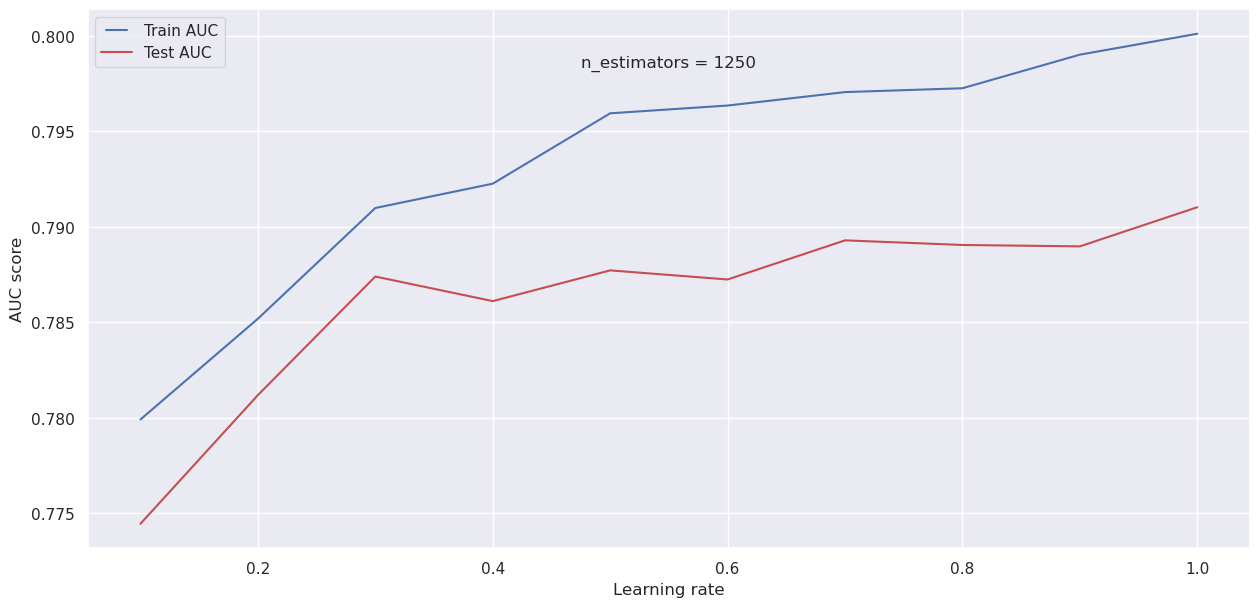

In [39]:
# Tuning learning_rate, with n_estimators=1250
tuning_auc(X_train, y_train, X_test, y_test, learning_rates = np.linspace(0.1, 1, 10), n_estimators = 1250)

From the graph, the optimal learning rate appears to be 1, as this is where the AUC score is highest for the testing set.

#### Results

The following table summarizes the evaluation scores obtained after training the model with the optimal parameters `learning_rate = 1` and `n_estimators = 1250`.

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy score |   0.8576          |   0.8678        |
| F-score        |   0.7246          |   0.7457        |
| ROC-AUC score  |   0.7716          |   0.7910        |

<a id="6"></a>
## 6. Reviewing the Model

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will take two steps to potentially improve our AdaBoost classifier's performance. First, we will identify the most important features of the model and explore the effect of reducing the feature space on the model's performance. Second, we will apply Robust Scaling to the numerical features in the dataset to mitigate the impact of outliers, and compare the performance of the model trained on this scaled data to the performance of the model trained on the Min-Max scaled data used in our previous analysis.</p></div>

<a id="6.1"></a>
### 6.1. Feature Importance

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section we will identify which features provide more predictive power in our tuned AdaBoost classifier.</p></div><br>

An important task when performing supervised learning on a dataset, like the census data we study here, is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is mostly always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that strongly predict whether an individual makes at most or more than $50,000.

Using the `feature_importance_` attribute from AdaBoostClassifier, we will determine the top 5 most important features for the census dataset.

In [40]:
# Creating visualization code to plot the feature importances

def feature_plot(importances, n, X_train, y_train):
    """
    Visualization code to display feature importances.
    
    Parameters:
      - importances (np.ndarray): Array of feature importances
      - n (int): Number of most important features to plot
      - X_train (pd.DataFrame): Training data features
      - y_train (pd.Series): Training data target
    """
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n]]
    values = importances[indices][:n]

    # Creating the plot
    fig = plt.figure(figsize = (9,5))
    plt.title(f"Normalized Weights for First {n} Most Predictive Features", fontsize = 14)
    plt.bar(np.arange(n), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(n) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(n), columns)
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

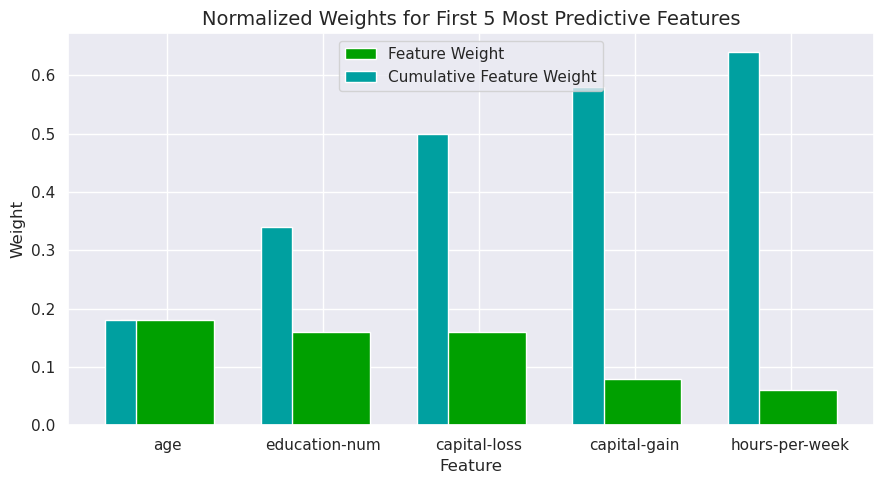

In [41]:
# Extracting the feature importances
importances = clf_ada.feature_importances_

# Plotting feature importances
feature_plot(importances, 5, X_train, y_train)

The most important features, listed in order of descending importance, are: `capital-loss`, `age`, `capital-gain`, `hours-per-week`, and `education-num`.

From the visualization above, we see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn. With less features required to train, the expectation is that training and prediction times are much lower, at the cost of performance metrics.

The following code will use the same AdaBoostClassifier optimized earlier, and train it on the same training set with only the top five most important features.

In [42]:
# Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Training on optimized AdaBoost classifier
clf = AdaBoostClassifier(n_estimators=1250, random_state=42)
clf.fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions["test"])))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions["test"], beta = 0.5)))
print("ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions["test"])))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))
print("ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.8678
F-score on testing data: 0.7457
ROC-AUC score on testing data: 0.7910

Final Model trained on reduced data
------
Accuracy on testing data: 0.8432
F-score on testing data: 0.7045
ROC-AUC score on testing data: 0.7179


When training the model using only the five most important features, instead of all thirteen features, accuracy drops by approx. 3% (from 0.8678 to 0.8432), the F-score drops by approx. 5.5% (from 0.7457 to 0.7045) and the ROC-AUC score drops by approx. 9% (from 0.7910 to 0.7179).

Although a reduced dataset may simplify the model and shorten its training time, there is often a trade-off between model complexity and performance. A simpler model may be preferable in some cases, even if it comes at the cost of reduced performance. In other cases, such as when performance is the primary concern, a more complex model may be necessary.

For this scenario, *we will continue working with the complete feature space*, since sacrificing a 9% in the model's ROC-AUC score is not acceptable in exchange for a simpler and faster-to-train model. The AdaBoost classifier's training and prediction times were already low (2.14s an 0.13s, respectively), making it unnecesarry to reduce the feature space to this extent. Nonetheless, this approach helps us understand which features are the most influential in making predictions.

In [43]:
# Calculating the 10 most important features
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:10]]
values = importances[indices][:10]

for col, val in zip(columns, values):
    print(col, '--', val)

age -- 0.18
education-num -- 0.16
capital-loss -- 0.16
capital-gain -- 0.08
hours-per-week -- 0.06
occupation_ Machine-op-inspct -- 0.02
relationship_ Own-child -- 0.02
relationship_ Not-in-family -- 0.02
occupation_ Tech-support -- 0.02
occupation_ Protective-serv -- 0.02


However, upon calculating the top ten most important features of the model, we see how the top five features are all numerical, and categorical features only start to appear after that.

This can be attributed to the use of One-Hot Encoding to encode categorical features, which can affect their relative importance. When One-Hot encoding is used, the categorical variables are split into multiple binary variables, and each binary variable is treated as a separate feature. As a result, the relatvie importance of the categorical feature can be reduced and the model may assign a higher importance to numerical fetures, which typically have a wider range of values, also contributing to the feature importance.

As a workaround, we will use Label Encoding to encode the categorical variables. Label Encoding assigns labels between 0 and the number of classes - 1 to the categorical variables, avoiding the creation of additional features. We can then use the **Chi-squared test** together with `SelectKBest` to recalculate the feature importance. The Chi-squared test is a statistical test that compares observed results with expected results, determining whether any difference is due to chance of a relationship between the variables. [[30]](#ref-30) [[31]](#ref-31)

relationship -- 5243.79
capital-gain -- 2742.11
marital-status -- 1462.54
capital-loss -- 765.46
sex -- 684.09
occupation -- 304.42
age -- 282.21
education-num -- 238.65
hours-per-week -- 85.99
race -- 42.72
native-country -- 18.56
workclass -- 4.62


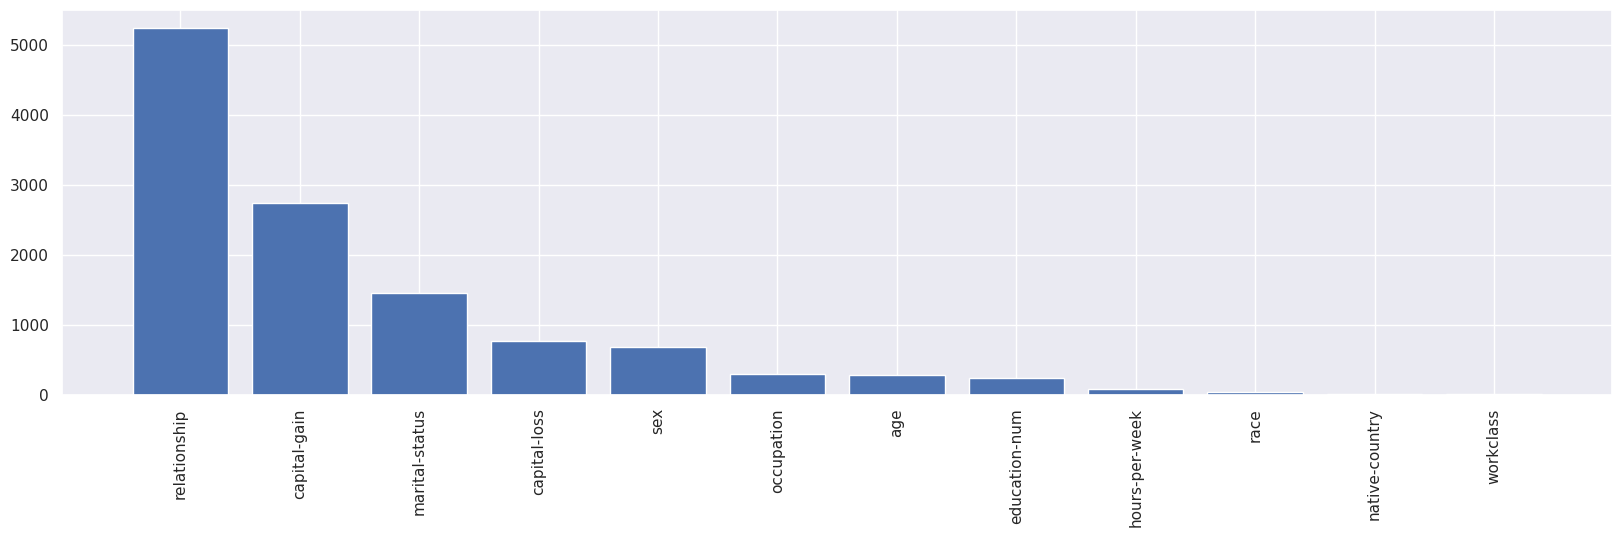

In [44]:
# Creating a copy of the original training data
data_chi2 = train_data.copy()

# Repeating feature engineering for new copy of data
# Apply log transformation on skewed numerical features
data_chi2[skewed] = log_transform(data_chi2)
# Min-Max scaling numerical features
data_chi2[num_col] = min_max_normalize(data_chi2[num_col])

# Encoding categorical features using LabelEncoder
label_encoder = LabelEncoder()
for col in cat_col:
    data_chi2[col] = label_encoder.fit_transform(data_chi2[col])
    
# Drop "education_level" from data for being equal to "education-num"
data_chi2.drop(["education_level", "income"], axis=1, inplace=True)

# Calculating feature importance using SelectKBest and chi2
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(data_chi2, income)

# Pair feature names with their scores and sort in descending order
sorted_features = sorted(data_chi2.columns, 
                         key=lambda x: fs.scores_[data_chi2.columns.get_loc(x)], reverse=True)

# Print the sorted feature names and their scores
for feature in sorted_features:
    score = fs.scores_[data_chi2.columns.get_loc(feature)]
    print("{} -- {:.2f}".format(feature, score))

# Plotting the scores
plt.bar(sorted_features, [fs.scores_[data_chi2.columns.get_loc(f)] for f in sorted_features])
plt.xticks(rotation=90)
plt.show()

From these calculations we can confirm some of the observations we made for categorical features in [section 4](#4). After vizualising the distributions for categorical features, we stated that:

- `"workclass"`, `"race"` and `"native-country"` exhibited class imbalance, suggesting they might not be good predictors of `"income"`. This turned out to be true, as these features are the least important according to the Chi-squared test.

- `"marital-status"`, `"occupation"`, `"relationship"` and `"sex"` displayed a clear separation of classes, indicating they might be good predictors of `"income"`. This is further supported by the fact that these features are the top most important categorical features according to the Chi-squared test.

- `"relationship"` and `"marital-status"` had very similar distributions, which is supported by the Chi-squared test since these two features are right next to each other in feature importance.

Now, let's repeat the process by selecting only the top five most important features calculated with this method, and train the optimized AdaBoostClassifier on the same training set to examine its performance.

In [45]:
# Splitting the new copy of data into training and testing sets
# Original data isn't valid becuase it was One-Hot encoded
X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(data_chi2,
                                                                        income,
                                                                        test_size = 0.2,
                                                                        random_state = 0)

# Reducing the feature space
new_importances = ['relationship', 'capital-gain', 'marital-status', 'capital-loss', 'sex']
X_train_reduced = X_train_chi2[new_importances]
X_test_reduced = X_test_chi2[new_importances]

# Training on optimized AdaBoost classifier
clf = AdaBoostClassifier(n_estimators=1250, random_state=42)
clf.fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions["test"])))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions["test"], beta = 0.5)))
print("ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions["test"])))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))
print("ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.8678
F-score on testing data: 0.7457
ROC-AUC score on testing data: 0.7910

Final Model trained on reduced data
------
Accuracy on testing data: 0.8280
F-score on testing data: 0.6748
ROC-AUC score on testing data: 0.6492


As it happened before, training the model with only the top five most important features reduces the model's performance in a considerable amount. Therefore, *we will continue working with the complete feature space*. We could discard the three less important features `"workclass"`, `"race"` and `"native-country"`, and it wouldn't have a significant impact on the evaluation scores. However, the model is already efficient in terms of training and prediction times, hence removing these features is not necessary.

<a id="6.2"></a>
### 6.2 Handling Outliers

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section we will scale the data using Robust Scaling to handle outliers in the numerical features, and check whether there is an improvement in the model's performance compared to the data scaled using Min-Max Scaling.</p></div><br>

As we saw in [section 4](#4), there are outliers in all continuous variables. To address these outliers, we will apply **Robust Scaling** to the data and evaluate the model's performance to determine if we can improve it with respect to the model trained on the Min-Max scaled data.

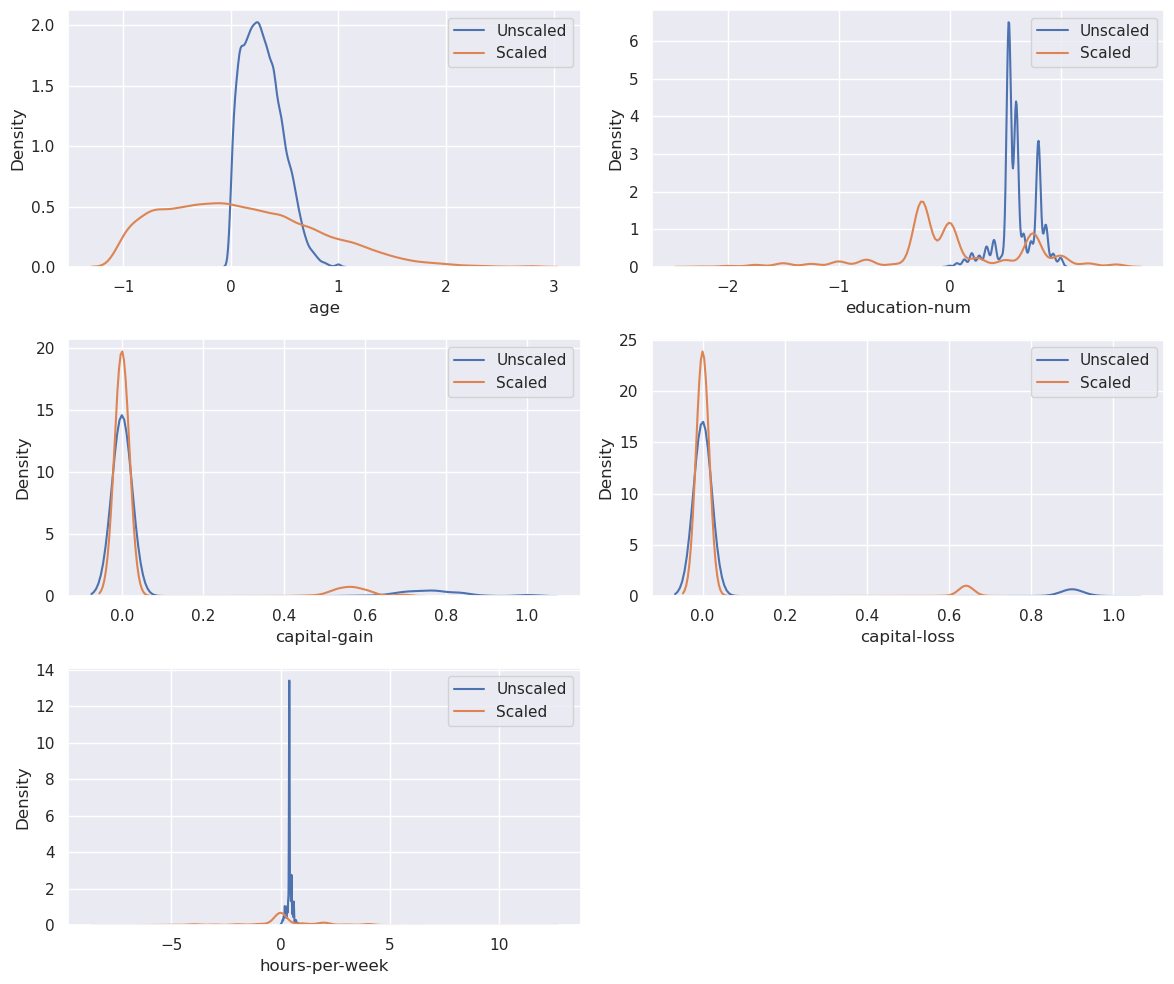

In [46]:
# Creating a copy of the original training data
data_outliers = train_data.copy()

# Repeating feature engineering for new copy of data
# Apply log transformation on skewed numerical features
data_outliers[skewed] = log_transform(data_outliers)

# Scaling numerical columns with Robust Scaler
scaler = RobustScaler()
data_outliers[num_col] = scaler.fit_transform(data_outliers[num_col])

# Drop "education_level" from data for being equal to "education-num"
data_outliers.drop(["education_level", "income"], axis=1, inplace=True)

# Creating a grid of a 3x2 subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()
axes[5].set_visible(False) # Setting the last graph to invisible

# Plotting scaled and unscaled distributions
for i, feature in enumerate(num_col):
    
    # Unscaled distribution
    sns.kdeplot(data[feature], ax=axes[i], label='Unscaled')
    # Scaled distribution
    sns.kdeplot(data_outliers[feature], ax=axes[i], label='Scaled')
    
    # Adding legend
    axes[i].legend()

plt.tight_layout()
plt.show()

We can observe a slight evening out of the distributions after applying Robust Scaling. However, the overall improvement is not substantial. Next, we will retrain the optimized model on the new scaled data and evaluate its performance again.

In [47]:
# One-Hot encoding categorical features from new copy of data
features_encoded_outliers = pd.get_dummies(data_outliers)

# Splitting the robust encoded dataset
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(features_encoded_outliers,
                                                                                        income,
                                                                                        test_size = 0.2,
                                                                                        random_state = 0)

# Training on optimized AdaBoost classifier
clf = AdaBoostClassifier(n_estimators=1250, random_state=42)
clf.fit(X_train_outliers, y_train)

# Making new predictions
scaled_predictions = clf.predict(X_test_outliers)

# Reporting scores from the final model using both versions of data
print("Final Model trained on Min-Max scaled data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions["test"])))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions["test"], beta = 0.5)))
print("ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions["test"])))
print("\nFinal Model trained on Robust scaled data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, scaled_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, scaled_predictions, beta = 0.5)))
print("ROC-AUC score on testing data: {:.4f}".format(roc_auc_score(y_test, scaled_predictions)))

Final Model trained on Min-Max scaled data
------
Accuracy on testing data: 0.8678
F-score on testing data: 0.7457
ROC-AUC score on testing data: 0.7910

Final Model trained on Robust scaled data
------
Accuracy on testing data: 0.8678
F-score on testing data: 0.7457
ROC-AUC score on testing data: 0.7910


The performance remains the same regardless of whether the numerical data is scaled using Robust Scaling or Min-Max Scaling. Therefore, *we will continue working with our original data and previously optimized model*, as seen in [section 5](#5).

<a id="7"></a>
## 7. Preprocessing the Testing Data

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will handle the missing values in the testing data to make it ready for prediction and submission.</p></div>

As seen in [section 3](#3), the *testing* dataset contains a total of 231 missing values. We will impute these missing values based on their respective variable distributions:

- **Numerical variables *with approx. Gaussian distributions***: Replace missing values with the mean from the *training* dataset.
- **Numerical variables *with skewed distributions***: Replace missing values with the median from the *training* dataset.
- **Categorical variables**: Replace the missing values with the most frequent category from the *training* dataset.

Missing values in the *testing* dataset will be replaced using the mean, median, mode, etc. from the *training* dataset, because it's important to use the same imputation strategy in both datasets to ensure consistency and fairness in the model's evaluation.

In [28]:
# Make a copy of the testing dataset to manipulate during feature engineering
data_test = test_data[:]

In [section 4](#4) we plotted the distributions of numerical features. From there we observe that `age`, `education-num` and `hours-per-week` have approx. Gaussian distributions, while `capital-gain` and `capital-loss` have skewed distributions.

In [49]:
# Imputing missing values for numerical features with approx. Gaussian distributions
for col in ["age", "education-num", "hours-per-week"]:
    data_test[col]= data_test[col].fillna(train_data[col].mean())

# Imputing missing values for numerical features with skewed distributions
for col in ["capital-gain", "capital-loss"]:
    data_test[col]= data_test[col].fillna(train_data[col].median())

# Imputing missing values for categorical features
cat_feat = [c for c in cat_col if c != "income"]
for col in cat_feat:
    data_test[col]= data_test[col].fillna(train_data.groupby([col])[col].count().sort_values(ascending=False).index[0])

In [50]:
# Percentage of null values in training set
total_na = test_data.isnull().sum().sum()
print("Total number of missing values in testing dataset is {} or {:.2f}%".format(total_na, 100*(total_na/test_data.shape[0])))

Total number of missing values in testing dataset is 0 or 0.00%


Next, we will preprocess the *testing* dataset just like we did with the *training* dataset. First, we will apply a Log transformation to the skewed continuous features, followed by Min-Max scaling the numerical features, and lastly, One-Hot encoding the categorical features.

In [51]:
# Log transformation of skewed data
data_test[skewed] = log_transform(data_test)

# Min-Max scaling of numerical features
data_test[num_col] = min_max_normalize(data_test[num_col])

# One-Hot Encoding of all the features (except "education_level")
features_encoded_test = pd.get_dummies(data_test.drop(["education_level"], axis = 1))
print("Total features after One-Hot Encoding:", len(list(features_encoded_test.columns)))

Total features after One-Hot Encoding: 87


The *testing* dataset is ready for prediction and submission.

<a id="8"></a>
## 8. Predicting and Submitting

<div style="border-radius:5px; background-color:#f5f5f5; display: flex; padding-left: 15px;">
    <span style="padding-top: 12px; padding-right: 10px;">📌</span>
    <p style="padding: 12px 15px 0 0;">In this section, we will use the optimized AdaBoost classifier to predict the income for the testing dataset, and submit the results.</p></div>

As a reminder, `best_clf` is an **AdaBoost Classifier** with hyperparameters: `learning_rate` = 1, and `n_estimators` = 1250.

In [ ]:
# Predicting target variable "income" for testing dataset
predictions_test = best_clf.predict(features_encoded_test)

In [ ]:
# Creating the final submission file
submission = pd.DataFrame(columns=["id", "income"])
submission["income"] = predictions_test
submission["id"] = pd.read_csv("../input/udacity-mlcharity-competition/test_census.csv", usecols=[0])

# Generating CSV
submission.to_csv("/kaggle/working/submission.csv", index=False)

### Conclusion

<div style="border-radius:5px; border: 1px solid #f2f2f2; padding: 15px; display: inline-block; margin: 20px; font-family: Consolas;">
    🔸 The best score obtained with our model was: 0.79839</div>

This score was achieved by single model, namely an **AdaBoost Classifier** with `learning_rate` = 1 and `n_estimators` = 1250. However, there are other strategies for improving performance beyond optimizing the model's hyperparameters. One such strategy is to create an Ensemble Voting Classifier.

An **Ensemble Voting Classifier** combines the predictions from multiple individual models, which can improve the overall performance by leveraging the strengths of each model and compensating for their weaknesses. There are two main ways a voting classifier can improve the model [[32]](#ref-32):

- **Combining different types of models**: Such as Decision Trees, Logistic Regression, and Support Vector Machines, which can help capture different aspects of the data and improve the overall performance of the predictions.

- **Combining models with different hyperparameters**: By combining models with different hyperparameters, a voting classifier can find the best combination of hyperparameters for the problem, which can lead to a better performance than any individual model.

When combining the predictions of multiple individual models in an ensemble voting classifier, there are two main voting criteria that can be used to make a final prediction [[33]](#ref-33):

- **Hard Voting**: Each individual model in the ensemble predicts a class label for the input data, and the final prediction is based on the majority vote among the individual models.

- **Soft Voting**: Each individual model in the ensemble predicts the *probability* of the input belonging to each class, and the final prediction is made by taking the average of the predicted probabilities across all individual models and selecting the class label with the highest average probability.

Overall, using an ensemble voting classifier can improve the generalization of the final model, by reducing the impact of any individual model that may be biased or overfitting to the training data, and reduce overfitting by averaging out the predictions of the individual models.

> **Further work** could involve using an ensemble voting classifier to improve the results. However, this method will not be carried out in this notebook. For more information on how to implement it, refer to the resource [[32]](#ref-32).

<a id="9"></a>
## References


- <a id="ref-01"></a> [[1]] "Oracle: Skewness" https://docs.oracle.com/cd/E57185_01/CBREG/ch03s02s03s01.html
- <a id="ref-02"></a> [[2]] "Protobi: Extreme values. Winsorize, trim or retrain" https://help.protobi.com/intermediate-editor/extreme-values-winsorize-trim-or-retain
- <a id="ref-03"></a> [[3]] "Machine Learning Mastery: How to scale data with outliers" https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/
- <a id="ref-04"></a> [[4]] "Google Developers: Machine Learning. Normalization" https://developers.google.com/machine-learning/data-prep/transform/normalization
- <a id="ref-05"></a> [[5]] "Machine Learning Mastery: How to use Power Transforms" https://machinelearningmastery.com/power-transforms-with-scikit-learn/
- <a id="ref-06"></a> [[6]] "Edvancer: Top 4 ways to encode categorical variables" https://edvancer.in/encode-categorical-variables
- <a id="ref-07"></a> [[7]] "Towards Data Science: Accuracy Precision, Recall or F1" https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
- <a id="ref-08"></a> [[8]] "Google Developers: Machine Learning. Classification: ROC Curve and AUC" https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
- <a id="ref-09"></a> [[9]] "Machine Learning Mastery: How to develop and evaluate Naive classifier strategies using probability" https://machinelearningmastery.com/how-to-develop-and-evaluate-naive-classifier-strategies-using-probability/
- <a id="ref-10"></a> [[10]] "Towards Data Science: Creating benchmark models the scikit-learn way" https://towardsdatascience.com/creating-benchmark-models-the-scikit-learn-way-af227f6ea977
- <a id="ref-11"></a> [[11]] "GeeksforGeeks: Advantages and Disadvantages of Logistic Regression" https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/
- <a id="ref-12"></a> [[12]] "Towards Data Science: Assumptions of Logistic Regression, Clearly Explained" https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290
- <a id="ref-13"></a> [[13]] "Notes on BSc CSIT: What are the Pros and Cons of using Naive Bayes" https://www.shikhadeep.com.np/2021/12/what-are-pros-and-cons-of-using-naive.html
- <a id="ref-14"></a> [[14]] "HolyPython: Naive Bayes Pros & Cons" https://holypython.com/nbc/naive-bayes-pros-cons/
- <a id="ref-15"></a> [[15]] "Wikipedia: Support Vector Machine - Applications" https://en.wikipedia.org/wiki/Support_vector_machine#Applications
- <a id="ref-16"></a> [[16]] "DataFlair: Real-Life Applications of SVM" https://data-flair.training/blogs/applications-of-svm/
- <a id="ref-17"></a> [[17]] "GeeksforGeeks: Support Vector Machine in Machine Learning" https://www.geeksforgeeks.org/support-vector-machine-in-machine-learning/
- <a id="ref-18"></a> [[18]] "Medium: Random Forests - Pros and Cons" https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04
- <a id="ref-19"></a> [[19]] "Medium: Why Random Forst is my favorite Machine Learning model" https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706
- <a id="ref-20"></a> [[20]] "Medium: Bagging and Boosting Method" https://medium.com/@ruhi3929/bagging-and-boosting-method-c036236376eb
- <a id="ref-21"></a> [[21]] "EDUCBA: Bagging and Boosting" https://www.educba.com/bagging-and-boosting/
- <a id="ref-22"></a> [[22]] "CompPhysics: Decision Trees, Random Forests, Bagging and Boosting" https://compphysics.github.io/MLSummerSchool/doc/pub/Day5/html/Day5-bs.html
- <a id="ref-23"></a> [[23]] "Towards AI: All About AdaBoost" https://pub.towardsai.net/all-about-adaboost-ba232b5521e9
- <a id="ref-24"></a> [[24]] "TowardsMachineLearning: What are Boosting Algorithms and how they work" https://towardsmachinelearning.org/boosting-algorithms/
- <a id="ref-25"></a> [[25]] "Scikit-learn Documentation: LogisticRegression" https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- <a id="ref-26"></a> [[26]] "Scikit-learn Documentation: SVC" https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- <a id="ref-27"></a> [[27]] "Scikit-learn Documentation: RandomForestClassifier" https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- <a id="ref-28"></a> [[28]] "Scikit-learn Documentation: BaggingClassifier" https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
- <a id="ref-29"></a> [[29]] "Scikit-learn Documentation: AdaBoostClassifer" https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- <a id="ref-30"></a> [[30]] "Medium: Label Encoder vs One-Hot Encoder" https://contactsunny.medium.com/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
- <a id="ref-31"></a> [[31]] "Wikipedia: Chi-squared test" https://en.wikipedia.org/wiki/Chi-squared_test
- <a id="ref-32"></a> [[32]] "Medium: Creating an Ensemble Voting Classifier with Scikit-Learn" https://towardsdatascience.com/creating-an-ensemble-voting-classifier-with-scikit-learn-ab13159662d
- <a id="ref-33"></a> [[33]] "Medium: Use Voting Classifier to improve the performance of your ML model" https://towardsdatascience.com/use-voting-classifier-to-improve-the-performance-of-your-ml-model-805345f9de0e

[1]: https://docs.oracle.com/cd/E57185_01/CBREG/ch03s02s03s01.html "Oracle: Skewness"
[2]: https://help.protobi.com/intermediate-editor/extreme-values-winsorize-trim-or-retain "Protobi: Extreme values. Winsorize, trim or retrain"
[3]: https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/ "Machine Learning Mastery: How to scale data with outliers"
[4]: https://developers.google.com/machine-learning/data-prep/transform/normalization "Google Developers: Machine Learning. Normalization"
[5]: https://machinelearningmastery.com/power-transforms-with-scikit-learn/"Machine "Learning Mastery: How to use Power Transforms"
[6]: https://edvancer.in/encode-categorical-variables "Edvancer: Top 4 ways to encode categorical variables"
[7]: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9"Towards "Data Science: Accuracy Precision, Recall or F1"
[8]: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc "Google Developers: Machine Learning. Classification: ROC Curve and AUC"
[9]: https://machinelearningmastery.com/how-to-develop-and-evaluate-naive-classifier-strategies-using-probability/ "Machine Learning Mastery: How to develop and evaluate Naive classifier strategies using probability"
[10]: https://towardsdatascience.com/creating-benchmark-models-the-scikit-learn-way-af227f6ea977 "Towards Data Science: Creating benchmark models the scikit-learn way" 
[11]: https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/ "GeeksforGeeks: Advantages and Disadvantages of Logistic Regression" 
[12]: https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290 "Towards Data Science: Assumptions of Logistic Regression, Clearly Explained"
[13]: https://www.shikhadeep.com.np/2021/12/what-are-pros-and-cons-of-using-naive.html "Notes on BSc CSIT: What are the Pros and Cons of using Naive Bayes"
[14]: https://holypython.com/nbc/naive-bayes-pros-cons/ "HolyPython: Naive Bayes Pros & Cons"
[15]: https://en.wikipedia.org/wiki/Support_vector_machine#Applications "Wikipedia: Support Vector Machine - Applications"
[16]: https://data-flair.training/blogs/applications-of-svm/ "DataFlair: Real-Life Applications of SVM"
[17]: https://www.geeksforgeeks.org/support-vector-machine-in-machine-learning/ "GeeksforGeeks: Support Vector Machine in Machine Learning"
[18]: https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04 "Medium: Random Forests - Pros and Cons"
[19]: https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706 "Medium: Why Random Forst is my favorite Machine Learning model" 
[20]: https://medium.com/@ruhi3929/bagging-and-boosting-method-c036236376eb "Medium: Bagging and Boosting Method" 
[21]: https://www.educba.com/bagging-and-boosting/ "EDUCBA: Bagging and Boosting"
[22]: https://compphysics.github.io/MLSummerSchool/doc/pub/Day5/html/Day5-bs.html "CompPhysics: Decision Trees, Random Forests, Bagging and Boosting"
[23]: https://pub.towardsai.net/all-about-adaboost-ba232b5521e9 "Towards AI: All About AdaBoost"
[24]: https://towardsmachinelearning.org/boosting-algorithms/ "TowardsMachineLearning: What are Boosting Algorithms and how they work"
[25]: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html "Scikit-learn Documentation: LogisticRegression"
[26]: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html "Scikit-learn Documentation: SVC"
[27]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html "Scikit-learn Documentation: RandomForestClassifier"
[28]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html "Scikit-learn Documentation: BaggingClassifier"
[29]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html "Scikit-learn Documentation: AdaBoostClassifer"
[30]: https://contactsunny.medium.com/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621 "Medium: Label Encoder vs One-Hot Encoder"
[31]: https://en.wikipedia.org/wiki/Chi-squared_test "Wikipedia: Chi-squared test"
[32]: https://towardsdatascience.com/creating-an-ensemble-voting-classifier-with-scikit-learn-ab13159662d "Medium: Creating an Ensemble Voting Classifier with Scikit-Learn" 
[33]: https://towardsdatascience.com/use-voting-classifier-to-improve-the-performance-of-your-ml-model-805345f9de0e "Medium: Use Voting Classifier to improve the performance of your ML model" 